# Contribution Analysis
In this notebook, I will examine the contributions calculated by LRP. There are two kinds of different contribution scores to every gene:
* A feature contribution that tells us how important each of the features were for the classification of that gene as being a cancer gene
* A neighbor contribution that tells us which of its interacting partners in the PPI were most important for the classification of that gene

There are several strategies to make use of the LRP contributions and I would like to examine a few of them here.

In [120]:
# data science & classics
import pandas as pd
import numpy as np
import h5py
import networkx as nx
import os, sys
import subprocess

# clustering & embedding
from sklearn.cluster import SpectralBiclustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy
import umap
import sklearn

# other modules of mine
import gcnIO, postprocessing, utils
sys.path.append(os.path.abspath('../pancancer/preprocessing'))
import preprocessing_utils as pre_utils

import sharepathway as sp

# GO enrichment analysis
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT as GeneID2nt_human
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
sys.path.append(os.path.abspath('../pancancer'))
import preprocessing_utils as ut

# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.rc('font', family='Arial')
%matplotlib inline

## Relevant Paths
* `achilles_data_path`: Path to the achilles CRSIPR gene effect csv file that can be downloaded [here](https://depmap.org/portal/download/)
* `model_dir`: Path to the training directory where both, the model and the LRP contributions are stored.

In [3]:
achilles_data_path = '../data/pancancer/Achilles/Achilles_gene_effect.csv'
model_dir = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/'

In [4]:
def get_hhotnet_results():
    all_clusters = []
    all_genes = []
    with open('../../hierarchical-hotnet/examples/results/clusters_mynetwork.tsv', 'r') as f:
        for line in f.readlines():
            if not line.startswith('#'): # exclude comments
                cluster = [i.strip() for i in line.split('\t')]
                if len(cluster) == 1:
                    break
                all_clusters.append(cluster)
                all_genes += cluster
    return all_clusters, all_genes


def get_cancer_genes():
    # get the NCG cancer genes
    known_cancer_genes = []
    candidate_cancer_genes = []
    n = 0
    with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                known_cancer_genes.append(l[0])
                candidate_cancer_genes.append(l[1])
            else:
                candidate_cancer_genes.append(l[0])

    oncokb_genes = pd.read_csv('../data/pancancer/oncoKB/cancerGeneList.txt', sep='\t')
    return oncokb_genes, known_cancer_genes, candidate_cancer_genes


def plot_rolling_avg(ax, data, window_size=200):
    rolling_avg = data.rolling(window=window_size).median()
    sns.lineplot(x=range(data.shape[0]), y=rolling_avg)
    plt.fill_between(range(data.shape[0]), rolling_avg)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


def get_pathway_enrichment(genes, universe, cluster_idx, out_dir, clean_up=True):
    # write cluster information to disk
    genes.set_index('ID').to_csv(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)), sep='\t')
    universe.set_index('ID').to_csv(os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)), sep='\t')

    # formulate command to hand to R script
    cmd = 'Rscript KEGG.R {} {} {} {}'.format(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)),
                                              os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)),
                                              os.path.join(out_dir, 'cluster_{}_pathways.txt'.format(cluster_idx)),
                                              genes.shape[0]
                                          )
    res = subprocess.call(cmd, shell=True)
    # read pathways and return
    top_pathways = pd.read_csv(os.path.join(model_dir, 'cluster_{}_pathways.txt'.format(cluster_idx)),
                               sep='\t')[['Pvalue', 'Count', 'Size', 'Term']].head(5)
    
    if clean_up:
        os.remove(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)))
        os.remove(os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)))

    return top_pathways


def plot_representative(ax, rep, rep_std, xlabels, title=None):
    ax.bar(x=np.arange(len(xlabels)), height=rep.values, tick_label=xlabels)#, yerr=rep_std.values)
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', labelsize=16)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    if not title is None:
        ax.set_title(title, fontsize=18)
    ax.set_ylabel('Feature\nContribution', fontsize=18)
    utils.colorize_by_omics(ax, xlabels)


def plot_representative_heatmap(ax, rep, xlabels, title=None):
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]
    vmax = x.max()
    vmin = x.min()
    print ("Max and min ", vmax, vmin)
    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


def plot_pathway_information(ax, pathways):
    for i in range(pathways.shape[0]):
        ax.text(0, 0.9-i*0.2, '{0}  {1:.2f}  {2}  {3}  {4}'.format(i+1, pathways.iloc[i]['Pvalue'],
                                                                   pathways.iloc[i]['Count'],
                                                                   pathways.iloc[i]['Size'],
                                                                   pathways.iloc[i]['Term']
                                                                  ), fontsize=12
               )
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

## Load the Clustering Results

In [5]:
args, _ = gcnIO.load_hyper_params(model_dir)
with h5py.File(args['data'], 'r') as f:
    node_names = f['gene_names'][:]
    feature_names = f['feature_names'][:]
    adjacency = f['network'][:]
    features = f['features'][:]
feature_contributions = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'feat_mean_all.npy'))
# replace 0 values with small random ones to prevent numerical issues
feat_contrib_df = pd.DataFrame(feature_contributions, index=node_names[:feature_contributions.shape[0], 1], columns=feature_names)
zero_rows = feat_contrib_df[(feat_contrib_df == 0).all(axis=1)]
feat_contrib_df.loc[(feat_contrib_df == 0).all(axis=1)] = np.random.randn(*zero_rows.shape)*0.00001
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])

In [6]:
pred = postprocessing.load_predictions(model_dir)

In [7]:
(feat_contrib_df == 0).all(axis=1).sum()

0

## Hierarchical Clustering/Biclustering of the Input Features

Selected 1000 Genes for Hierarchical Clustering


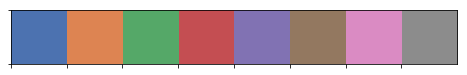

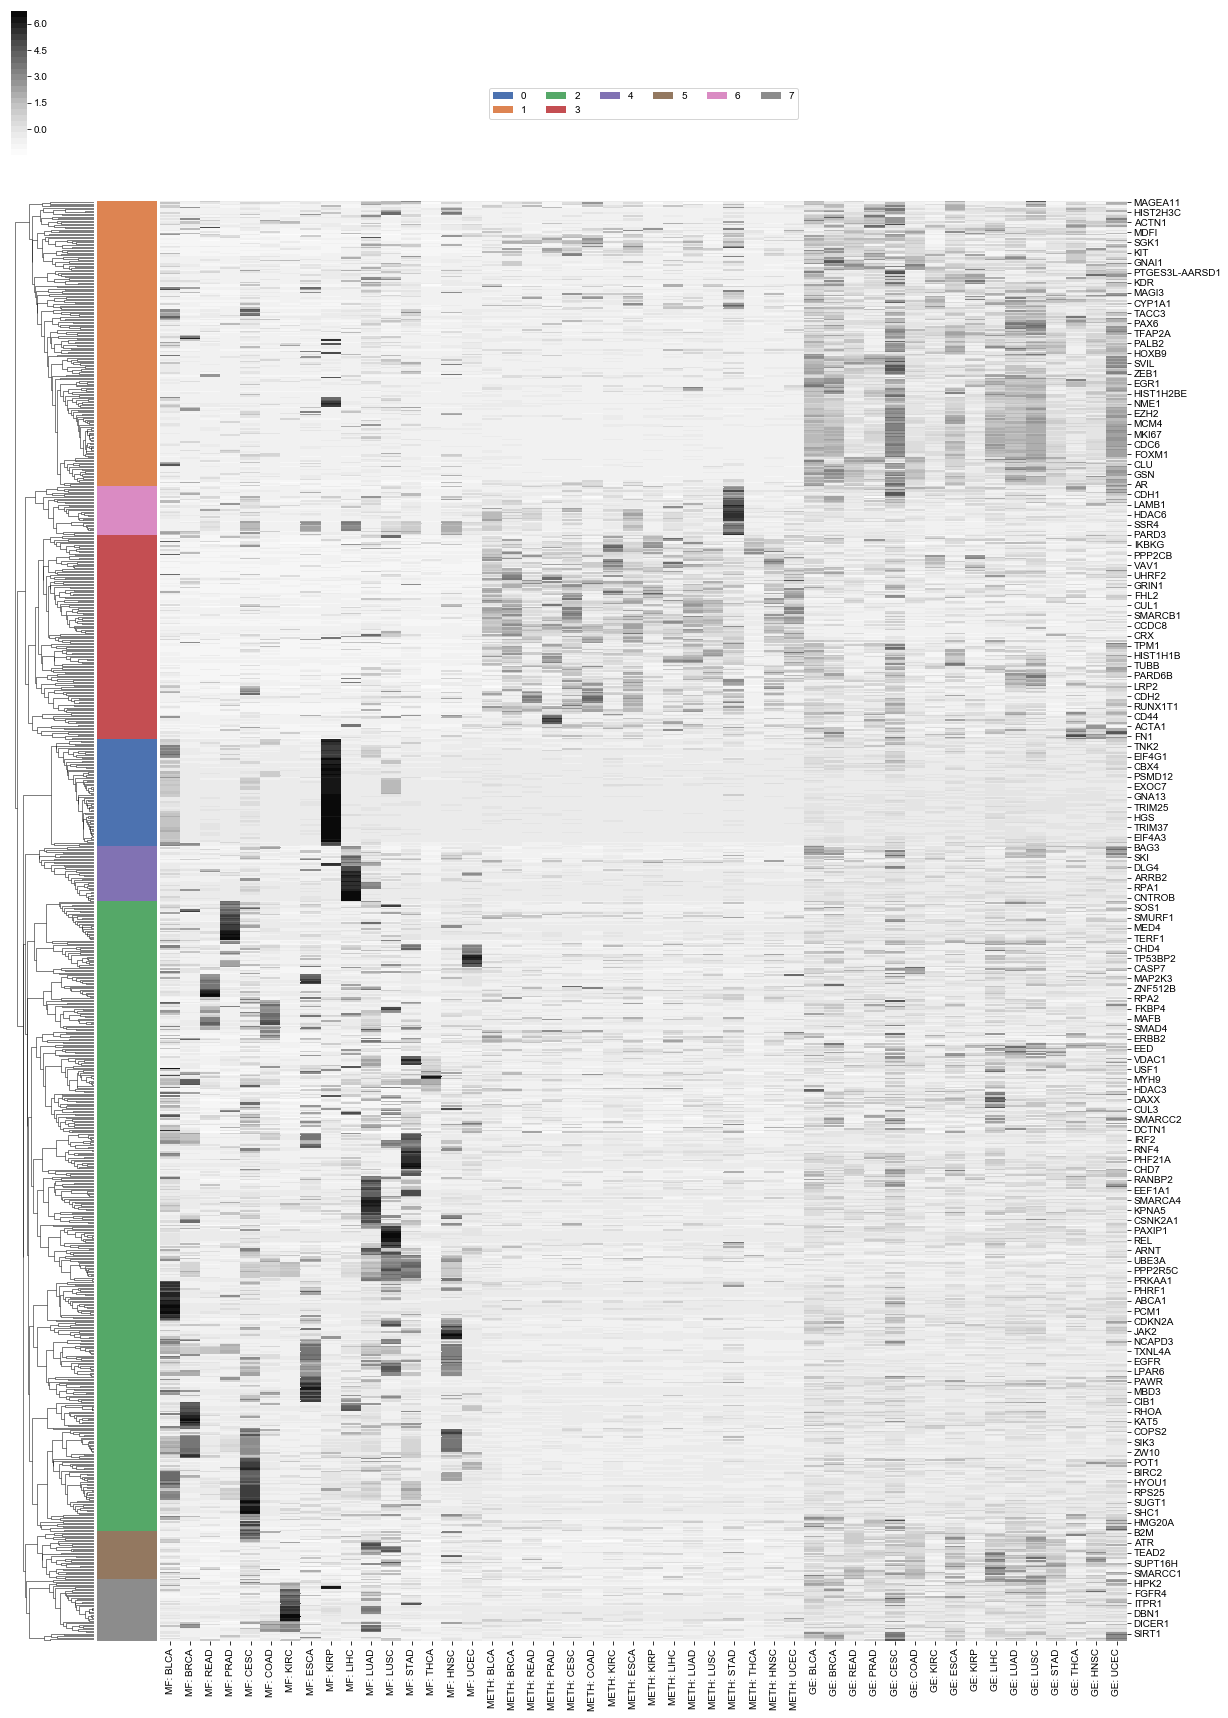

In [6]:
feat_df = pd.DataFrame(features, index=node_names[:, 1], columns=feature_names)
high_feat = feat_df[feat_df.index.isin(pred.head(1000).Name)]
#high_feat_contrib = feat_contrib_df[feat_contrib_df.index.isin(pred[pred.Prob_pos > 0.95].Name)]
#high_feat = high_feat[high_feat.sum(axis=1).between(-1, 1)]
print ("Selected {} Genes for Hierarchical Clustering".format(high_feat.shape[0]))

# compute the linkage matrix prior to the seaborn clustermap
from sklearn import preprocessing
Z_highconf = hierarchy.linkage(preprocessing.StandardScaler().fit_transform(high_feat), method='average', metric='correlation')
# compute flat clusters from that
flat_clusters = hierarchy.cut_tree(Z_highconf, n_clusters=8)
flat_clusters_series = pd.Series(flat_clusters.reshape(-1))
# map flat clusters to colors for plotting in the heatmap
lut_flatclu = dict(zip(flat_clusters_series.unique(),
                       sns.color_palette("deep", n_colors=flat_clusters_series.nunique())))
flat_rowcols_highconf = flat_clusters_series.map(lut_flatclu)
sns.palplot(lut_flatclu.values())

# get the literature information on known cancer genes
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv').set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(high_feat.shape[0])
onco_tsg_annotation[high_feat.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[high_feat.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=high_feat.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
row_colors = onco_tsg_annotation.map(lut)

# perform the clustering

clu = sns.clustermap(high_feat,
                     row_linkage=Z_highconf,
                     z_score=0, # axis 0
                     #standard_scale=0,
                     metric='euclidean',
                     figsize=(20, 30),
                     col_cluster=False,
                     yticklabels=7,
                     row_colors=[flat_rowcols_highconf],
                     #robust=True,
                     cmap=sns.color_palette("Greys", n_colors=25)
                    )

# plot the cluster indices as legend
for c in flat_clusters_series.unique():
    clu.ax_col_dendrogram.bar(0, 0, color=lut_flatclu[c],
                            label=c, linewidth=0)
clu.ax_col_dendrogram.legend(loc="center", ncol=6)

#clu.savefig(os.path.join(model_dir, 'clustering_lrp_highconf.png'), dpi=300)

## Heatmap to visualize clusters of important features

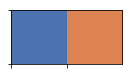

In [6]:
# compute the linkage matrix prior to the seaborn clustermap
Z = hierarchy.linkage(feat_contrib_df, method='average', metric='correlation')
# compute flat clusters from that
flat_clusters = hierarchy.cut_tree(Z, n_clusters=2)
flat_clusters_series = pd.Series(flat_clusters.reshape(-1))
# map flat clusters to colors for plotting in the heatmap
lut_flatclu = dict(zip(flat_clusters_series.unique(), sns.color_palette("deep", n_colors=flat_clusters_series.nunique())))
flat_rowcols = flat_clusters_series.map(lut_flatclu)
sns.palplot(lut_flatclu.values())

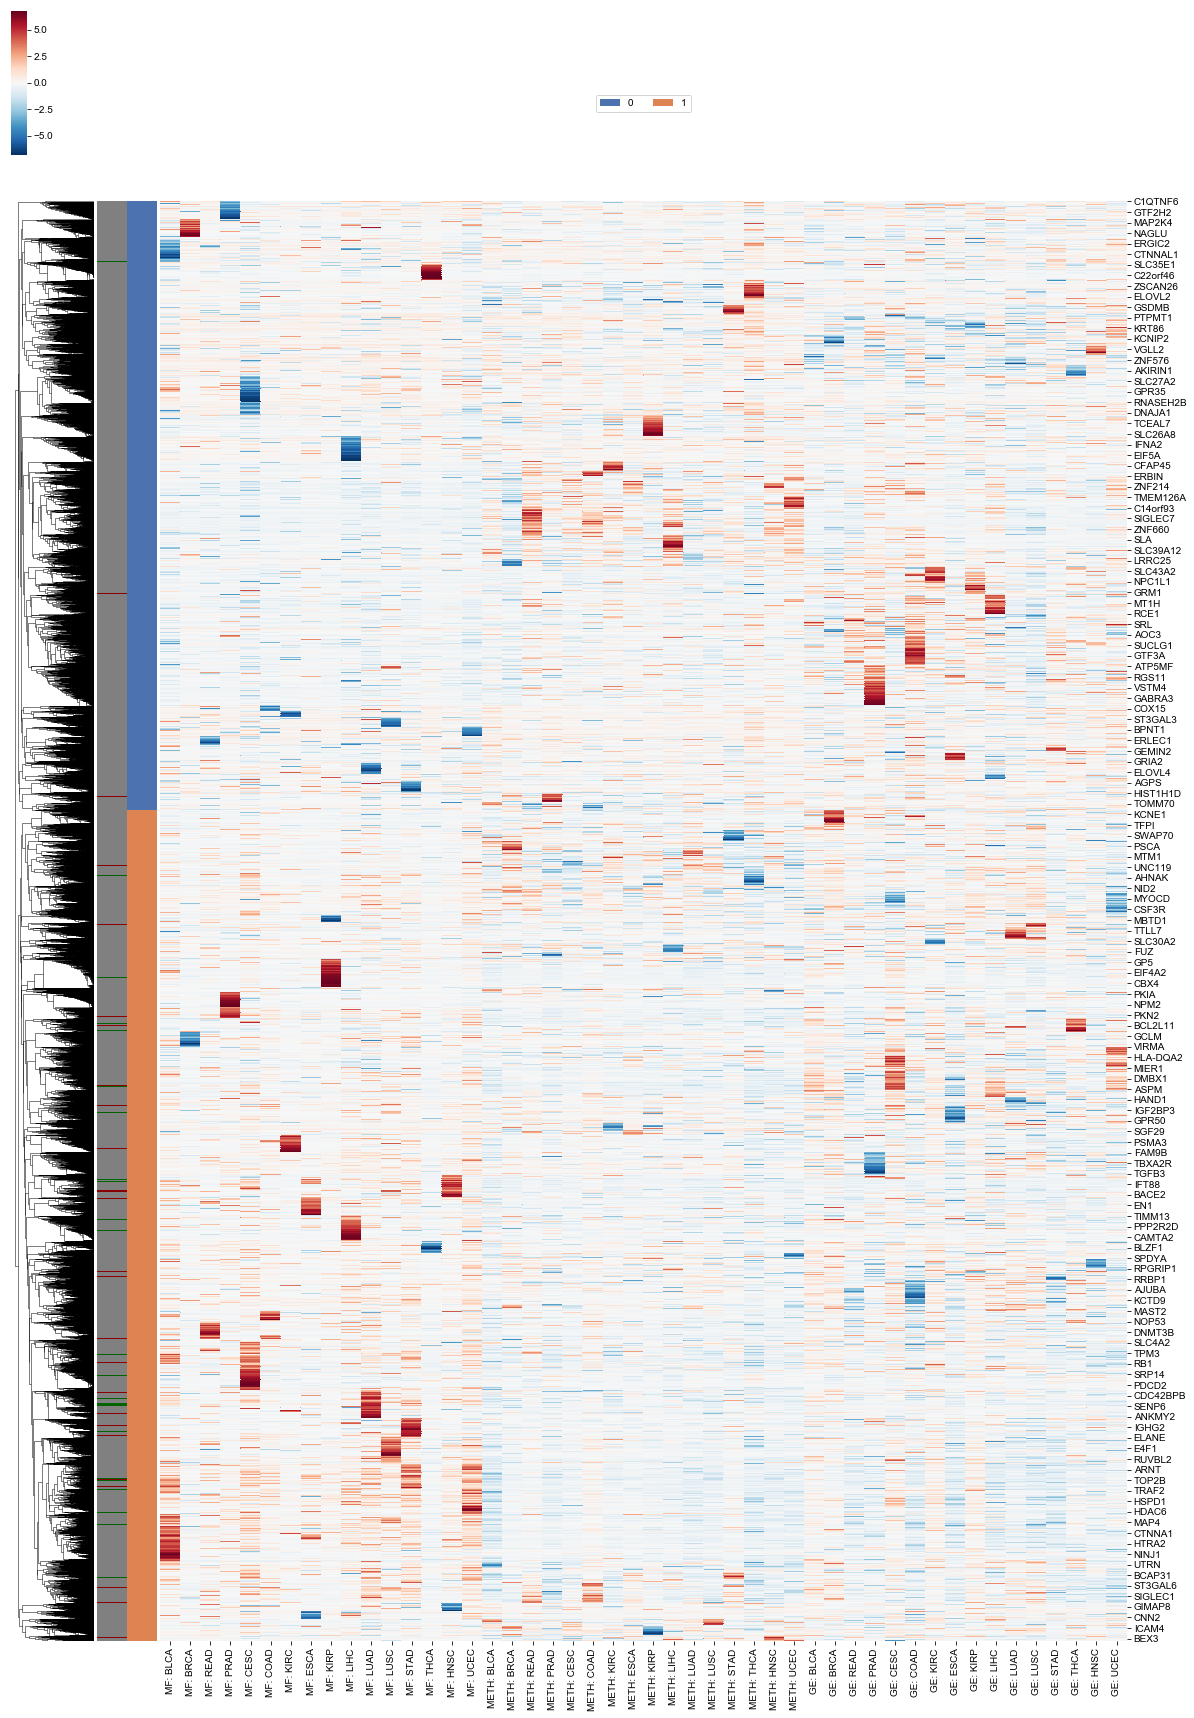

In [8]:
sys.setrecursionlimit(10000)

# get the literature information on known cancer genes
"""
oncokb, known, candidate = get_cancer_genes()
arr = np.zeros(feat_contrib_df.shape[0])
arr[feat_contrib_df.index.isin(known)] = 1
arr[feat_contrib_df.index.isin(candidate)] = 2
#arr[feat_contrib_df.index.isin(oncokb['Hugo Symbol'])] = 3
df = pd.Series(arr, index=feat_contrib_df.index, name='Literature Knowledge')
"""
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv').set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(feat_contrib_df.shape[0])
onco_tsg_annotation[feat_contrib_df.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[feat_contrib_df.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=feat_contrib_df.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
row_colors = onco_tsg_annotation.map(lut)

# perform the clustering
clu = sns.clustermap(feat_contrib_df,
                     #row_linkage=Z,
                     z_score=0, # axis 0
                     metric='correlation',
                     figsize=(20, 30),
                     col_cluster=False,
                     yticklabels=100,
                     row_colors=[row_colors, flat_rowcols],
                     cmap="RdBu_r"
                    )
# put in a fake legend that shows clusters
for c in flat_clusters_series.unique():
    clu.ax_col_dendrogram.bar(0, 0, color=lut_flatclu[c],
                            label=c, linewidth=0)
clu.ax_col_dendrogram.legend(loc="center", ncol=6)
clu.savefig(os.path.join(model_dir, 'clustering_lrp_allgenes.png'), dpi=300)

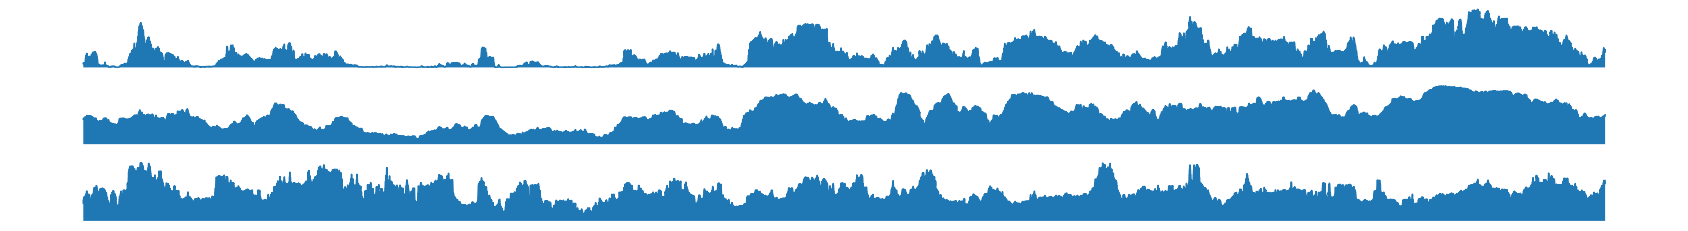

In [9]:
feature_contribution_sum = pd.Series(feat_contrib_df.sum(axis=1), name='Feature_Sum')
feat_contrib_predictions = pred.join(feature_contribution_sum, on='Name')
feat_contrib_predictions['Diff'] = feat_contrib_predictions.Feature_Sum / (feat_contrib_predictions.Prob_pos + 0.0001)
feat_contrib_predictions['Idx_Num'] = range(feat_contrib_predictions.shape[0])

feature_contribs_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Feature_Sum']
predictions_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Prob_pos']
diff_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Diff']




fig = plt.figure(figsize=(30, 4))
ax = plt.subplot(3, 1, 1)
plot_rolling_avg(ax, feature_contribs_dendroindex)
ax = plt.subplot(3, 1, 2)
plot_rolling_avg(ax, predictions_dendroindex)
ax = plt.subplot(3, 1, 3)
plot_rolling_avg(ax, diff_dendroindex)
fig.savefig(os.path.join(model_dir, 'feature_contribution_density_allgenes.png'), dpi=300)

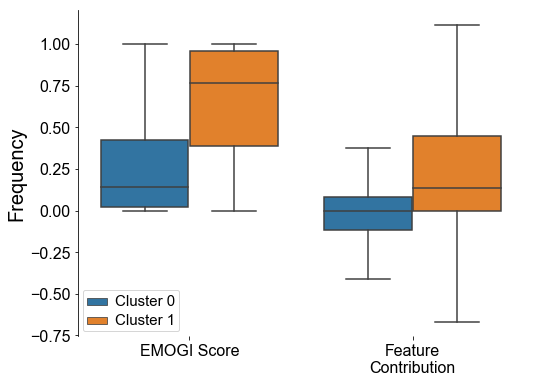

In [10]:
n_clusters_boxplots = 2
feat_vs_node = hierarchy.cut_tree(clu.dendrogram_row.linkage, n_clusters=n_clusters_boxplots) # the first cluster are mutation driven, the second not

cluster_label_list = ['Cluster {}'.format(i) for i in range(n_clusters_boxplots)]

feat_vs_node_series = pd.Series(feat_vs_node.reshape(-1))
nodes_with_cluster = nodes.copy()
nodes_with_cluster['Cluster'] = feat_vs_node
nodes_cluster_pred = nodes_with_cluster.join(pred.drop('Name', axis=1), on='ID').set_index('Name')
nodes_enriched = nodes_cluster_pred.join(feat_contrib_df.sum(axis=1).rename('Feature_Contribution'))
nodes_enriched.loc[nodes_enriched.label.isnull(), 'label'] = 0
nodes_enriched.loc[nodes_enriched.label == True, 'label'] = 1
nodes_enriched.loc[nodes_enriched.label == False, 'label'] = 0

fig = plt.figure(figsize=(8, 6))
g = sns.boxplot(data=pd.melt(nodes_enriched.drop(['label', 'Std_Pred', 'Num_Pos'], axis=1), id_vars=['ID', 'Cluster']),
            x='variable', y='value', hue='Cluster', showfliers=False)
plt.xlabel(None)
plt.ylabel('Frequency', fontsize=20)
for t, l in zip(g.legend().texts, cluster_label_list):
    t.set_text(l)
    t.set_size(15)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#plt.gca().get_xaxis().set_visible(False)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(['EMOGI Score', 'Feature\nContribution'])
fig.savefig(os.path.join(model_dir, '{}_clusters_difference_allgenes.svg'.format(n_clusters_boxplots)))

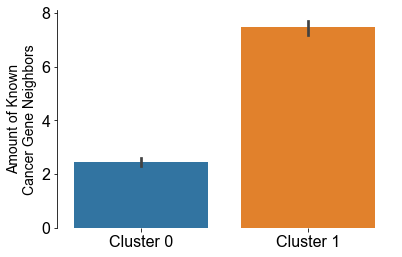

In [11]:
fig = plt.figure(figsize=(6, 4))
A = pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1])
num_known_neighbors = A[A.index.isin(pred[pred.label == True].Name)].sum(axis=0).rename('Num_Cancer_Gene_Neighbors')
sns.barplot(data=nodes_enriched.join(num_known_neighbors)[['Cluster', 'Num_Cancer_Gene_Neighbors']], x='Cluster', y='Num_Cancer_Gene_Neighbors')
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Amount of Known\nCancer Gene Neighbors', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
fig.savefig(os.path.join(model_dir, '{}_clusters_cancerneighbors_allgenes.svg'.format(n_clusters_boxplots)))

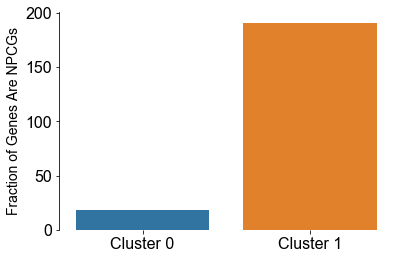

In [12]:
fig = plt.figure(figsize=(6, 4))
npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
npcgs.set_index('Name', inplace=True)
nodes_enriched['NPCG'] = 0
nodes_enriched.loc[nodes_enriched.index.isin(npcgs.index), 'NPCG'] = 1
npcgs_cl = [nodes_enriched[nodes_enriched.Cluster == i].NPCG.sum() for i in range(n_clusters_boxplots)]
sns.barplot(x=cluster_label_list, y=npcgs_cl)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Fraction of Genes Are NPCGs', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
fig.savefig(os.path.join(model_dir, '{}_clusters_npcgs_allgenes.svg'.format(n_clusters_boxplots)))

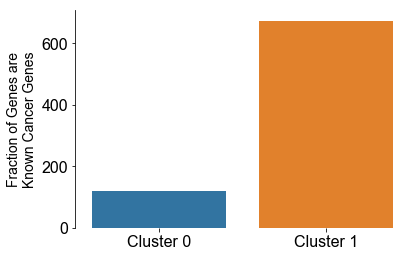

In [13]:
fig = plt.figure(figsize=(6, 4))
cgs = [nodes_enriched[nodes_enriched.Cluster == i].label.sum() for i in range(n_clusters_boxplots)]
#sns.barplot(data=nodes_enriched[['Cluster', 'label']], x='Cluster', y='label')
sns.barplot(x=cluster_label_list, y=cgs)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Fraction of Genes are\nKnown Cancer Genes', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
fig.savefig(os.path.join(model_dir, '{}_clusters_literature_allgenes.svg'.format(n_clusters_boxplots)))

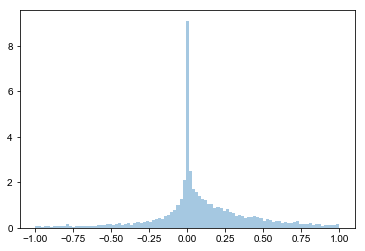

In [14]:
bins = np.linspace(-1, 1, 100)
sns.distplot(feat_contrib_df.sum(axis=1), bins=bins, kde=False, hist_kws={'density': True})
#plt.xlim([-10, 10])

## Compute Cluster Representatives and Pathway Enrichment

In [15]:
cluster_pathway_information = []
for cluster_number in flat_clusters_series.unique():
    cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
    cluster_genes = nodes[nodes.Name.isin(feat_contrib_df.iloc[cluster_gene_indices].index)]
    #cluster_genes = nodes_highfeat[nodes_highfeat.index.isin(cluster_gene_indices)]
    #print ("Cluster {} contains {} genes".format(cluster_number, cluster_genes.shape[0]))
    top_pathways = get_pathway_enrichment(cluster_genes, cluster_number, model_dir)
    cluster_pathway_information.append((cluster_number, top_pathways))

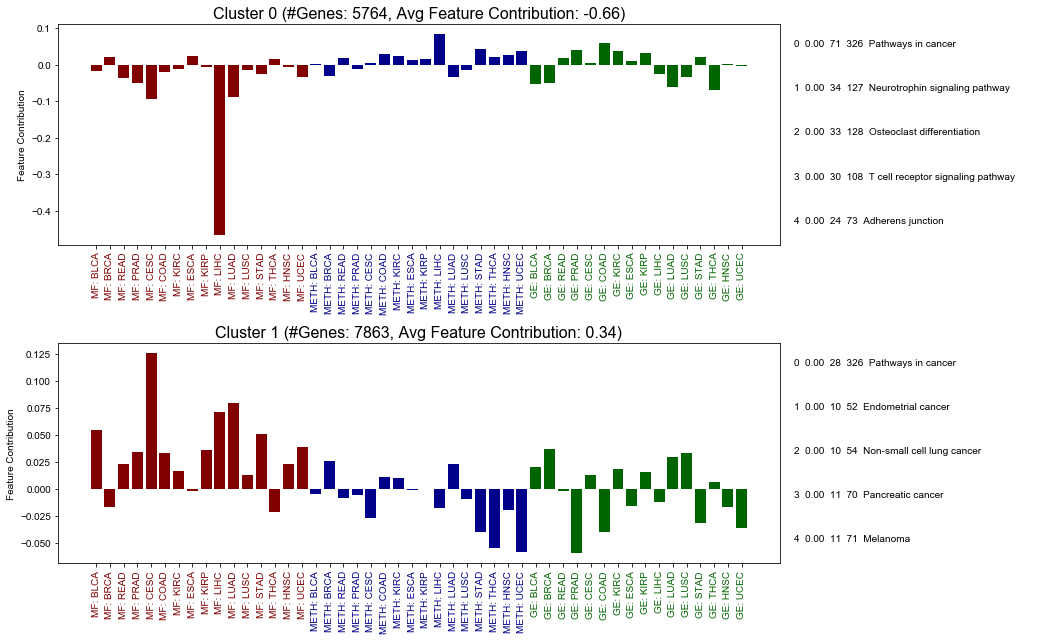

In [19]:
sum_of_all = 0
n_clusters = flat_clusters_series.nunique()
fig, axes = plt.subplots(nrows=n_clusters, ncols=2,
                         figsize=(15, n_clusters*3 + 3),
                         gridspec_kw={'width_ratios': [3, 1]}
                        )


for cluster_number in flat_clusters_series.unique():
    # find the genes in the current cluster
    cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
    cluster_genes = nodes[nodes.Name.isin(feat_contrib_df.iloc[cluster_gene_indices].index)]
    
    # compute the representative for that cluster
    features_of_cluster = feat_contrib_df.iloc[cluster_gene_indices]
    representative = features_of_cluster.mean(axis=0)
    representative_std = features_of_cluster.std(axis=0)
    # plot barplot for representative
    plot_representative(axes[cluster_number][0], representative, representative_std, representative.index,
                        title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(cluster_number,
                                                                                                    cluster_genes.shape[0],
                                                                                                    representative.sum()
                                                                                                   )
                       )
    # plot the pathways next to it
    plot_pathway_information(axes[cluster_number][1], cluster_pathway_information[cluster_number][1])
plt.tight_layout()
#fig.savefig(os.path.join(model_dir, 'cluster_representatives_{}.pdf'.format(flat_clusters_series.nunique())))

## Repeat Clustering for Top 1000 Genes

Optimal number of row clusters [17  1 30  2 36]
Optimal number of col clusters [1 5 2 3 9]


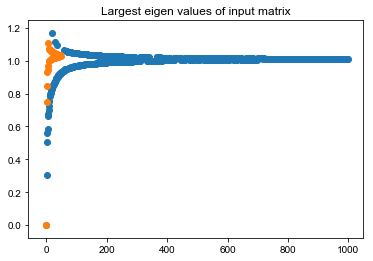

In [112]:
from scipy.spatial.distance import pdist, squareform

def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates))
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

import scipy
from scipy.sparse import csgraph
# from scipy.sparse.linalg import eigsh
from numpy import linalg as LA
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = LA.eig(L)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

from sklearn import metrics

def internalValidation(data, clusters):
    scores = {}
    """
    The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. 
    Scores around zero indicate overlapping clusters.
    The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
    """
    scores['_silhouette_score'] =metrics.silhouette_score(data,clusters ,metric='euclidean')
    """
    The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
    The score is fast to compute
    """
    scores['_calinski_harabaz_score'] = metrics.calinski_harabaz_score(data,clusters)
    """
    Zero is the lowest possible score. Values closer to zero indicate a better partition.
    The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, 
    such as density based clusters like those obtained from DBSCAN.
    """
    scores['_davies_bouldin_score'] = metrics.davies_bouldin_score(data,clusters)
    return scores


affinity_matrix = getAffinityMatrix(high_feat_contrib_normed, k = 10)
k, _,  _ = eigenDecomposition(affinity_matrix, plot=True)
print(f'Optimal number of row clusters {k}')

aff_mat_cols = getAffinityMatrix(high_feat_contrib_normed.T, k = 3)
k_col, _,  _ = eigenDecomposition(aff_mat_cols, plot=True)
print(f'Optimal number of col clusters {k_col}')

In [8]:
scores = []
combinations = []
for num_row_clusters in range(10, 30):
    for num_col_clusters in range(5, 20):
        #print (num_row_clusters, num_col_clusters)
        model = SpectralBiclustering(n_clusters=(num_row_clusters, num_col_clusters), method='bistochastic',
                                     svd_method='randomized', n_jobs=-1#, random_state=0
                                    )
        model.fit(high_feat_contrib_normed)
        score = metrics.silhouette_score(high_feat_contrib_normed, model.row_labels_ ,metric='euclidean')
        combinations.append((num_row_clusters, num_col_clusters))
        scores.append(score)

NameError: name 'SpectralBiclustering' is not defined

In [8]:
x = np.zeros((pd.Series(([i[0] for i in combinations])).nunique(),
              pd.Series(([i[1] for i in combinations])).nunique())
            )
x = pd.DataFrame(x, index=range(10, 30), columns=range(5, 20))
for i in range(len(combinations)):
    x.loc[combinations[i][0], combinations[i][1]] = scores[i]
sns.clustermap(x, method=None, row_cluster=False, col_cluster=False, annot=True)

NameError: name 'combinations' is not defined

Selected 999 Genes for Spectral Biclustering


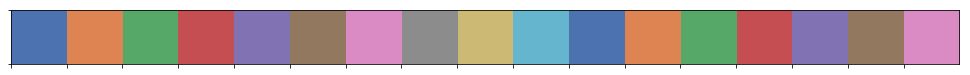

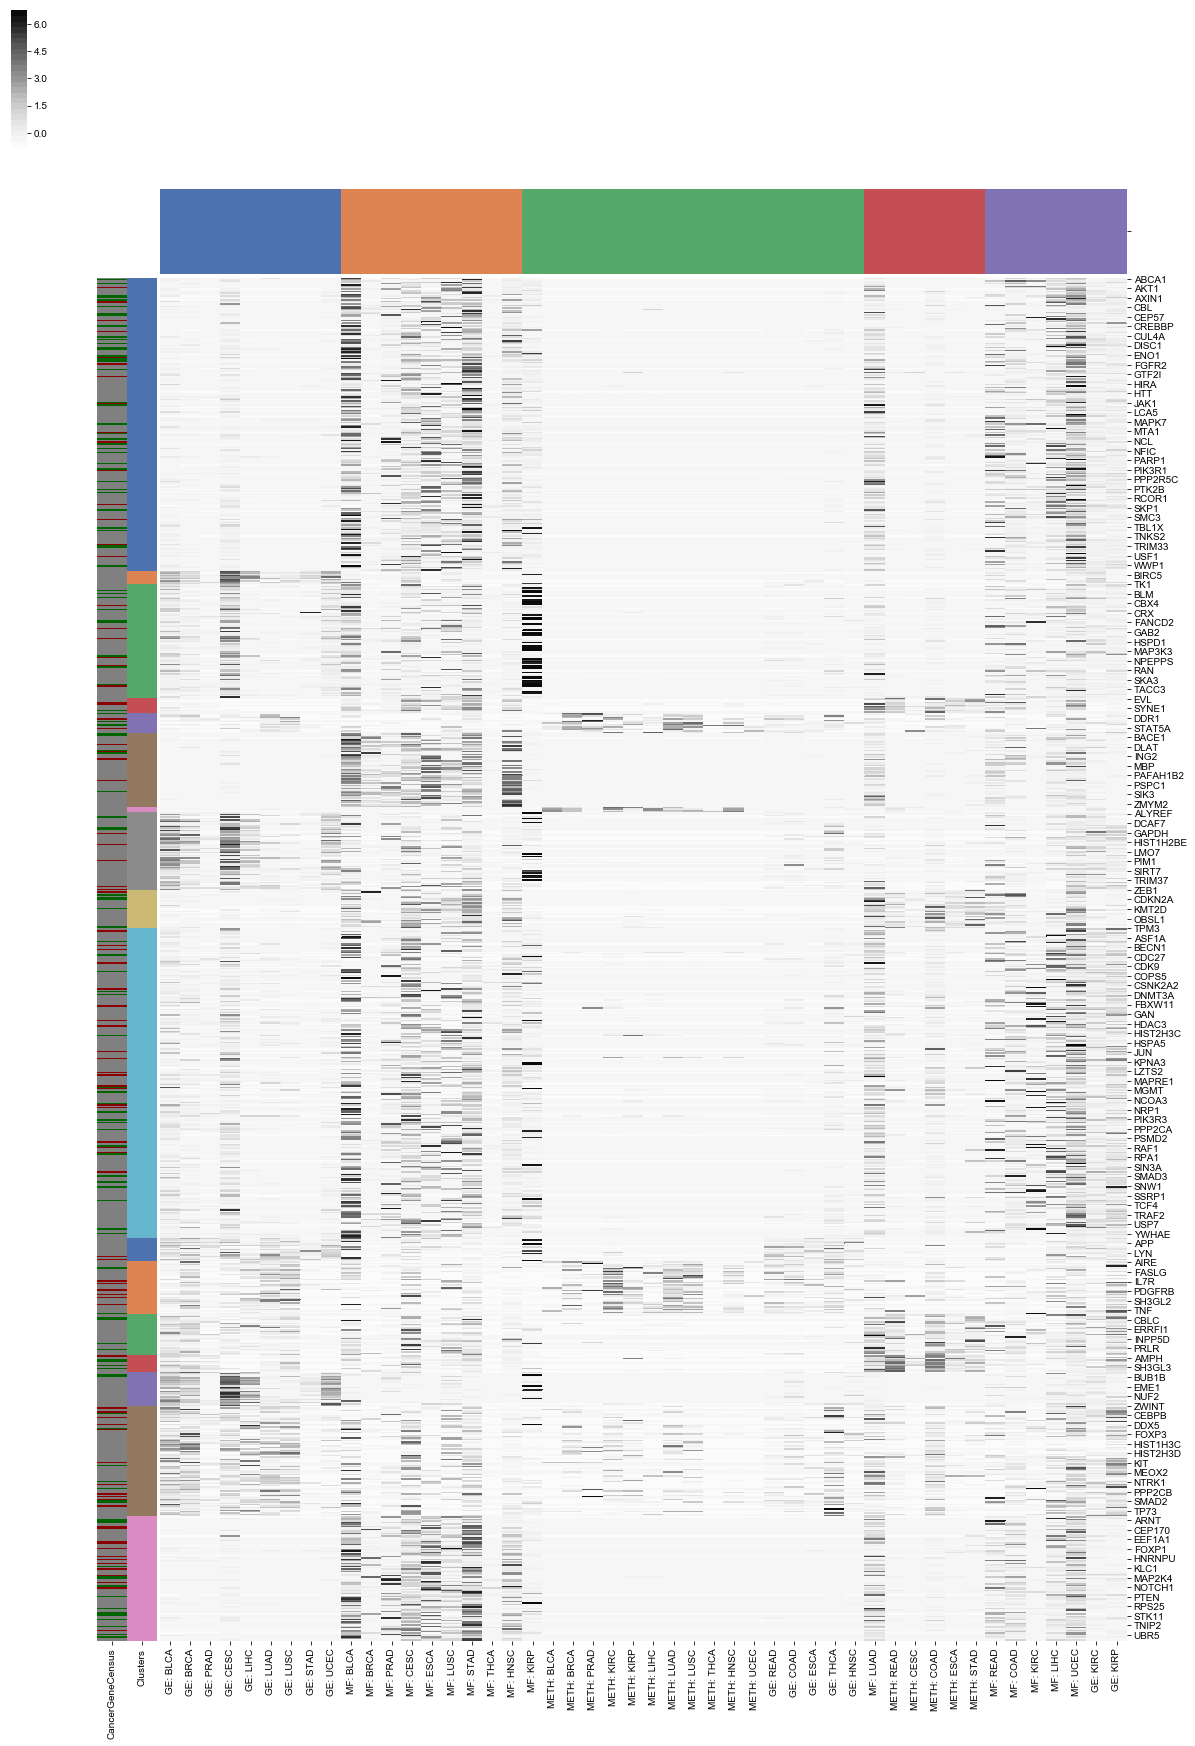

In [7]:
# select only top 1000 predictions
high_feat_contrib = feat_contrib_df[feat_contrib_df.index.isin(pred.head(1000).Name)]
#high_feat_contrib = feat_contrib_df[feat_contrib_df.index.isin(pred[pred.Prob_pos > 0.95].Name)]
high_feat_contrib = high_feat_contrib[high_feat_contrib.sum(axis=1).between(-1, 1)]
print ("Selected {} Genes for Spectral Biclustering".format(high_feat_contrib.shape[0]))

# remove negative contributions
high_feat_contrib_capped = high_feat_contrib.copy()
high_feat_contrib_capped[high_feat_contrib_capped < 0] = 0

n_clusters = (17, 5)
high_feat_contrib_normed = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(high_feat_contrib_capped),
                                        index=high_feat_contrib.index, columns=high_feat_contrib.columns)

model = SpectralBiclustering(n_clusters=n_clusters, method='bistochastic',
                             svd_method='randomized', n_jobs=-1, random_state=0
                            )
model.fit(high_feat_contrib_normed)
newOrder_row = [list(r) for r in zip(model.row_labels_, high_feat_contrib_normed.index)]
newOrder_row.sort(key=lambda k: (k[0], k[1]), reverse=False)
order_row = [i[1] for i in newOrder_row]
newOrder_col = [list(c) for c in zip(model.column_labels_, high_feat_contrib_normed.columns)]
newOrder_col.sort(key=lambda k: k[0], reverse=False)
order_col = [i[1] for i in newOrder_col]

# reorder the data matrix
X_plot = high_feat_contrib_capped.copy()
X_plot = X_plot.reindex(order_row) # rows
X_plot = X_plot[[str(x) for x in order_col]] # columns
X_plot.head()

lut_flatclu = dict(zip(list(range(max(n_clusters))),
                       sns.color_palette("deep", n_colors=max(n_clusters)))
                  )
sns.palplot(lut_flatclu.values())

# get the literature information on known cancer genes
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv').set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(high_feat_contrib.shape[0])
onco_tsg_annotation[high_feat_contrib.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[high_feat_contrib.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=high_feat_contrib.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
onco_tsg_colors = onco_tsg_annotation.map(lut)

row_cluster_colors = pd.Series(model.row_labels_, index=high_feat_contrib.index).map(lut_flatclu).rename('Clusters')
row_colors = pd.concat([onco_tsg_colors, row_cluster_colors], axis=1)

# use clustermap without clustering
cm=sns.clustermap(X_plot, method=None, metric='euclidean',
                  #cmap="RdBu_r",
                  cmap=sns.color_palette("Greys", n_colors=25),
                  row_cluster=False, col_cluster=False,
                  row_colors=row_colors,
                  col_colors=pd.Series(model.column_labels_, index=high_feat_contrib.columns).map(lut_flatclu),
                  yticklabels=7, xticklabels=1,
                  figsize=(20, 30),
                  standard_scale=None, z_score=0, robust=False
                 )
#cm.savefig(os.path.join(model_dir, 'biclustering_lrp_highconf.png'), dpi=300)

In [8]:
pd.Series(model.row_labels_, index=high_feat_contrib.index)['BRD1']

5

In [9]:
# relevant clusters are calculated by row_index * n_columns + col_index
# starting at 0. For instance, the cluster in in the 6th row and 2nd column (brown and orange)
# has number 5 * 5 + 1 = 26
relevant_clusters = [1, 26, 35, 49, 57, 63, 70, 81]

In [14]:
cluster_pathways_highconf = []
for cluster_number in relevant_clusters:
    subcluster = high_feat_contrib.iloc[model.get_indices(cluster_number)]
    genes = nodes[nodes.Name.isin(subcluster.index)]
    top_pathways = get_pathway_enrichment(genes, nodes, cluster_number, model_dir, clean_up=False)
    cluster_pathways_highconf.append((cluster_number, top_pathways))

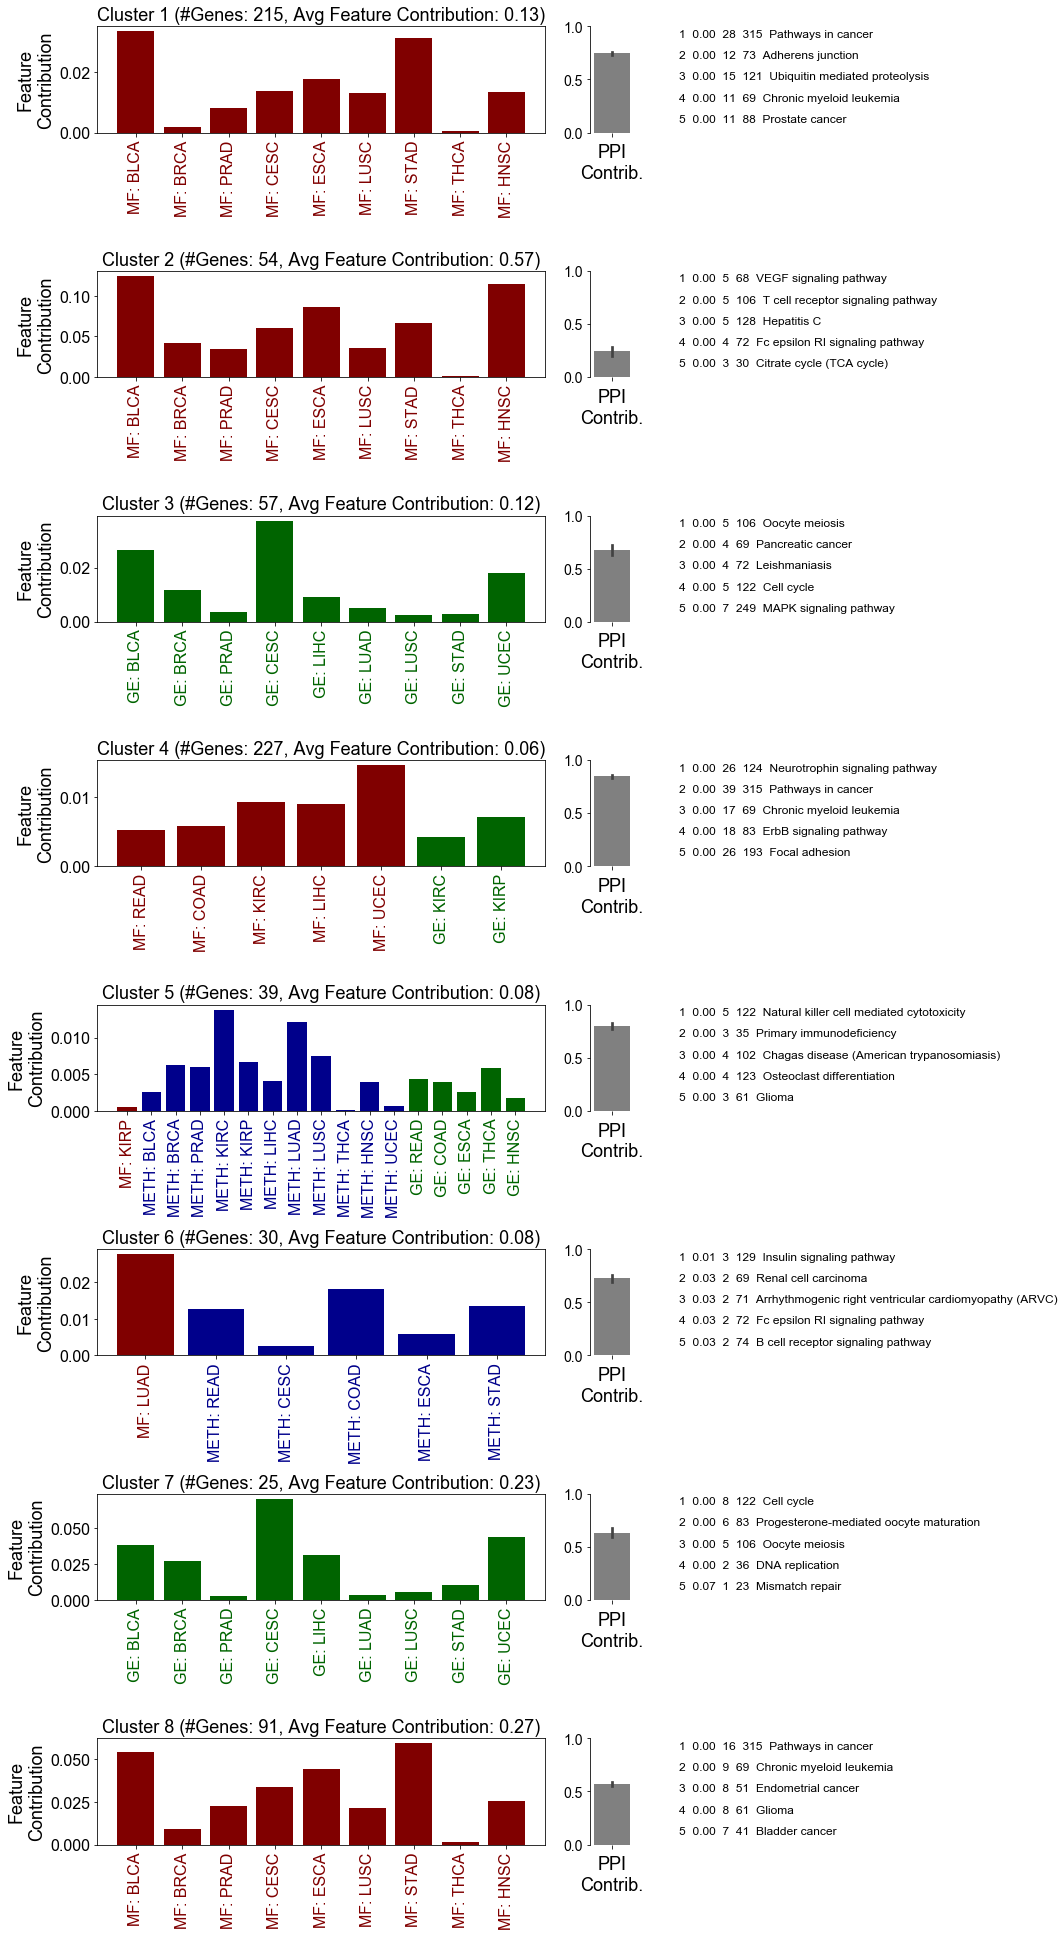

In [58]:
fig, axes = plt.subplots(nrows=len(relevant_clusters), ncols=3,
                         figsize=(15, len(relevant_clusters)*3 + 3),
                         gridspec_kw={'width_ratios': [5, 0.5, 3]}
                        )

plot_count = 0
for cluster_number in relevant_clusters:
    # find the genes in the current cluster
    subcluster = high_feat_contrib_capped.iloc[model.get_indices(cluster_number)]
    genes = nodes[nodes.Name.isin(subcluster.index)]
    
    # compute the representative for that cluster
    representative = subcluster.mean(axis=0)
    representative_std = subcluster.std(axis=0)
    # plot barplot for representative
    plot_representative(axes[plot_count][0], representative, representative_std, subcluster.columns.tolist(),
             title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(plot_count + 1,
                                                                                         genes.shape[0],
                                                                                         representative.sum()
                                                                                        )
            )

    # get network and feature contributions for the cluster
    all_features_cluster = high_feat_contrib_capped[high_feat_contrib_capped.index.isin(genes.Name)]
    sns.barplot(1-all_features_cluster.sum(axis=1), ax=axes[plot_count][1], orient='v', color='grey')
    axes[plot_count][1].set_ylim([0, 1])
    axes[plot_count][1].set_xlabel('PPI\nContrib.', fontsize=18)
    axes[plot_count][1].spines['right'].set_visible(False)
    axes[plot_count][1].spines['top'].set_visible(False)
    axes[plot_count][1].spines['bottom'].set_visible(False)
    axes[plot_count][1].tick_params(axis='y', labelsize=14)

    # plot the pathways next to it
    plot_pathway_information(axes[plot_count][2], cluster_pathways_highconf[plot_count][1])
    plot_count += 1

plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'bicluster_representatives_highconf.pdf'))

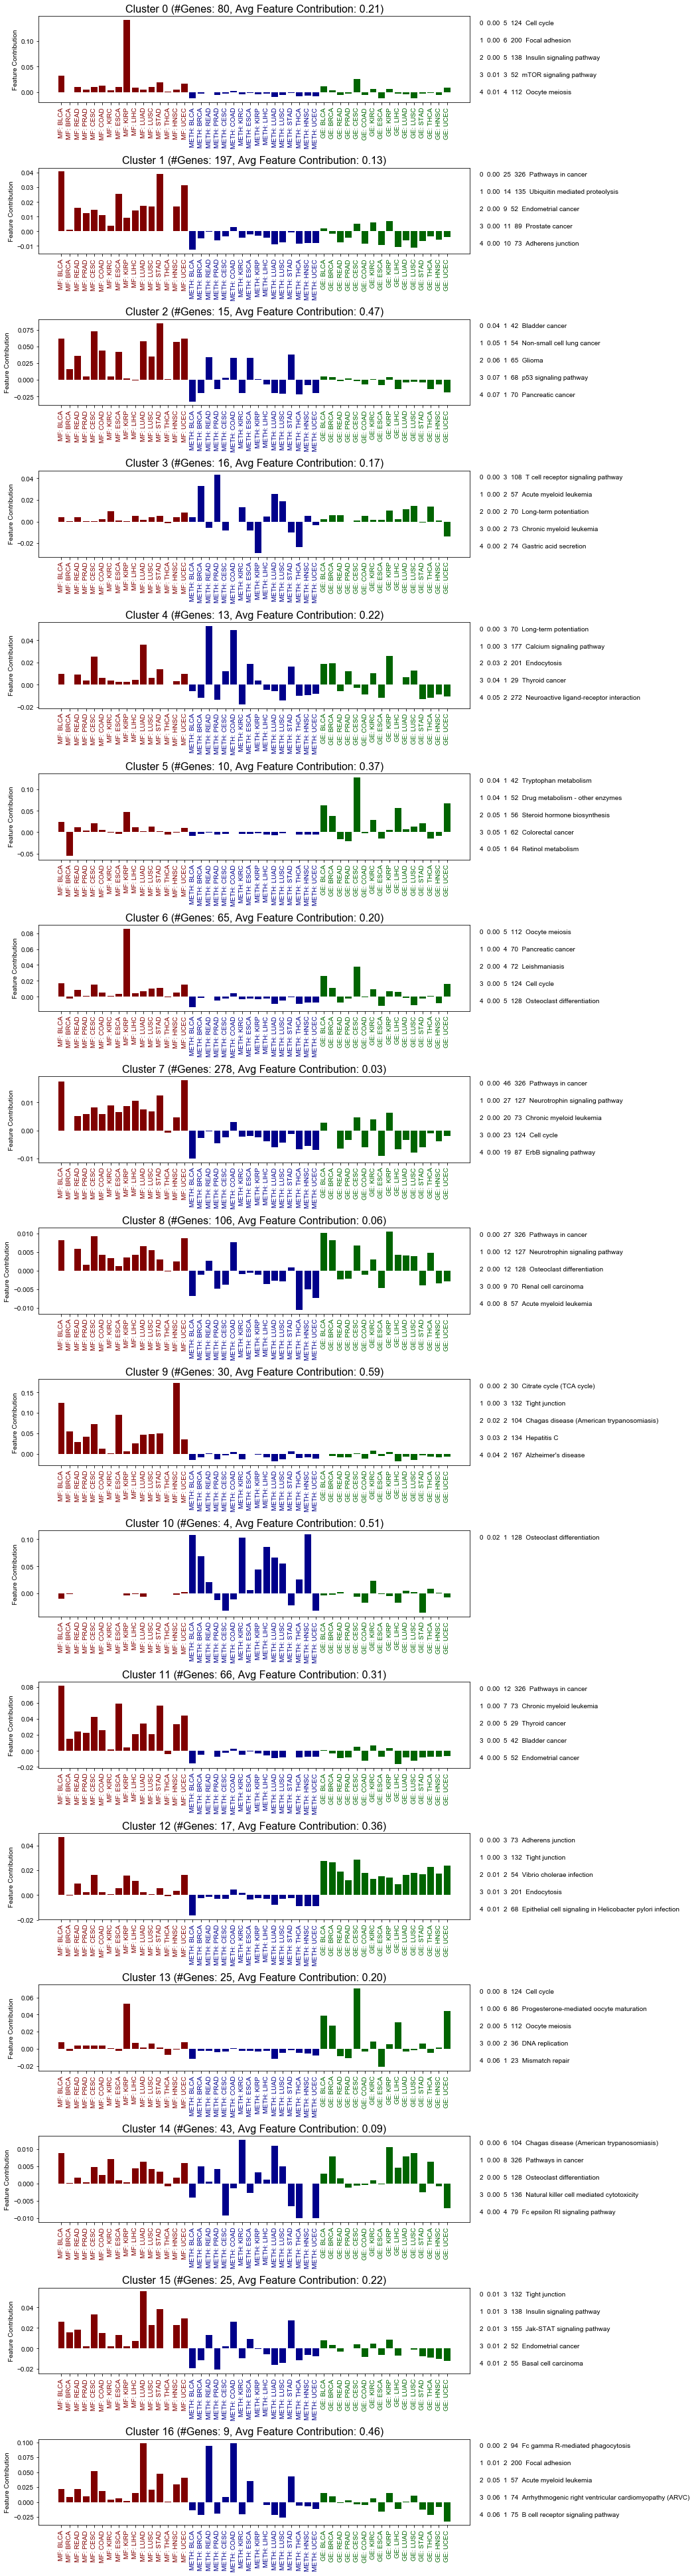

In [172]:
sum_of_all = 0
fig, axes = plt.subplots(nrows=n_clusters[0], ncols=2,
                         figsize=(15, n_clusters[0]*3 + 3),
                         gridspec_kw={'width_ratios': [3, 1]}
                        )

def plot_representative_heatmap(ax, rep, xlabels, title=None):
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]
    vmax = rep.max()
    vmin = rep.min()
    print ("Max and min ", vmax, vmin)
    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


for cluster_number in range(n_clusters[0]):
    # find the genes in the current cluster
    subcluster = high_feat_contrib.iloc[model.get_indices(cluster_number*n_clusters[1])]
    genes = nodes[nodes.Name.isin(subcluster.index)]
    
    # compute the representative for that cluster
    features_of_cluster = high_feat_contrib[high_feat_contrib.index.isin(genes.Name)]
    representative = features_of_cluster.mean(axis=0)
    representative_std = features_of_cluster.std(axis=0)
    # plot barplot for representative
    plot_representative(axes[cluster_number][0], representative, representative_std, v,
             title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(cluster_number,
                                                                                         genes.shape[0],
                                                                                         representative.sum()
                                                                                        )
            )
    # plot the pathways next to it
    plot_pathway_information(axes[cluster_number][1], cluster_pathways_highconf[cluster_number][1])
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'bicluster_representatives_highconf_{}.pdf'.format(flat_clusters_series.nunique())))

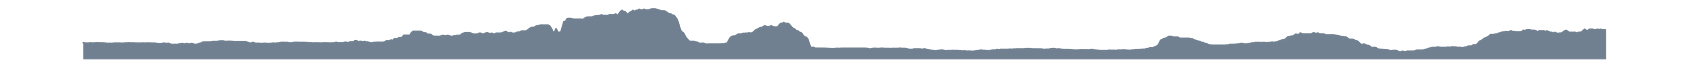

In [62]:
def plot_rolling_avg(ax, data, window_size=200):
    rolling_avg = data.rolling(window=window_size).median()
    sns.lineplot(x=range(data.shape[0]), y=rolling_avg, color='#708090')
    plt.fill_between(range(data.shape[0]), rolling_avg, color='#708090')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
feat_contrib_cmindex = X_plot.sum(axis=1).rename('Feature_Contribution')
fig = plt.figure(figsize=(30, 1))
ax = plt.subplot(1, 1, 1)
plot_rolling_avg(ax, feat_contrib_cmindex, window_size=30)
fig.savefig(os.path.join(model_dir, 'biclustering_density_contributions.png'), dpi=300)

Text(0, 0.5, 'Feature Contribution')

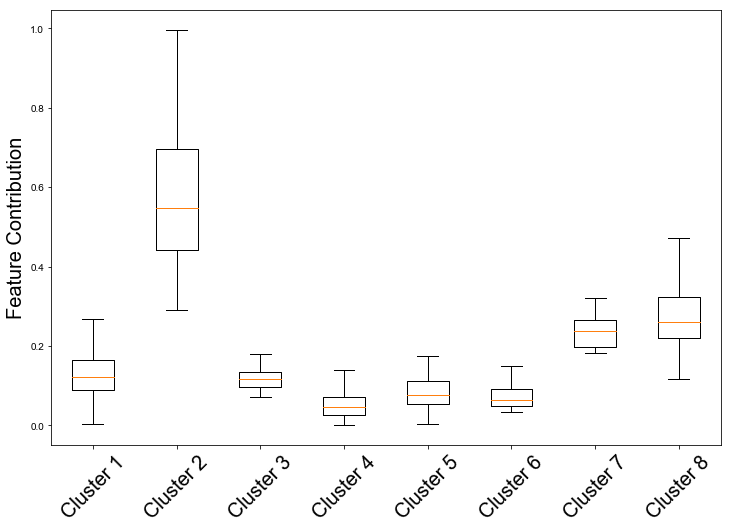

In [20]:
all_feat_contrib_sum = []
for cluster in relevant_clusters:
    submat = model.get_submatrix(cluster, data=high_feat_contrib_capped)
    feat_contrib_cluster = submat.sum(axis=1)
    all_feat_contrib_sum.append(feat_contrib_cluster)

fig = plt.figure(figsize=(12, 8))
_ = plt.boxplot(all_feat_contrib_sum, showfliers=False)
_ = plt.xticks(np.arange(1, len(relevant_clusters)+1), labels=['Cluster {}'.format(i+1) for i in range(len(relevant_clusters))],
               rotation=45, fontsize=20)
plt.ylabel('Feature Contribution', fontsize=20)

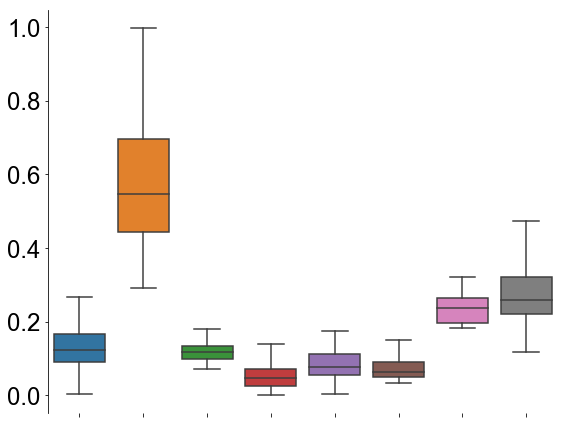

In [21]:
fig = plt.figure(figsize=(8, 6))
df_plot = pd.DataFrame(all_feat_contrib_sum)
df_plot['Cluster'] = df_plot.index.values + 1
sns.boxplot(data=df_plot.melt(id_vars=['Cluster']), x='Cluster', y='value', showfliers=False)
plt.gca().tick_params(axis='both', labelsize=24)
plt.gca().set_xticklabels([])
plt.ylabel(None, fontsize=20)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'cluster_stats_feat_contrib.svg'))

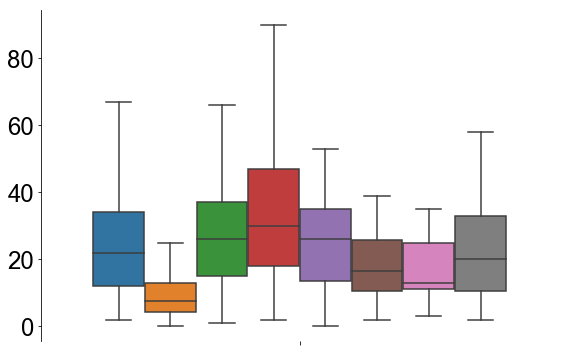

In [16]:
nodes_highconf = pd.DataFrame(high_feat_contrib.index.copy(), columns=['Name']).set_index('Name')
nodes_highconf['Cluster'] = model.row_labels_

nodes_highconf = nodes_highconf[nodes_highconf.Cluster.isin([0, 5, 7, 9, 11, 12, 14, 16])]

# put in the amount of feature contribution
nodes_highconf_pred = nodes_highconf.join(pred.set_index('Name'))
nodes_enriched = nodes_highconf_pred.join(high_feat_contrib.sum(axis=1).rename('Feature_Contribution'))

# put in the labels (known cancer genes)
nodes_enriched.loc[nodes_enriched.label.isnull(), 'label'] = 0
nodes_enriched.loc[nodes_enriched.label == True, 'label'] = 1
nodes_enriched.loc[nodes_enriched.label == False, 'label'] = 0

# put in number of cancer neighbors
A = pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1])
num_known_neighbors = A[A.index.isin(pred[pred.label == True].Name)].sum(axis=0).rename('Num_Cancer_Gene_Neighbors')
nodes_enriched = nodes_enriched.join(num_known_neighbors)

# put in the number of NPCGs per cluster
npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
npcgs.set_index('Name', inplace=True)
nodes_enriched['NPCG'] = 0
nodes_enriched.loc[nodes_enriched.index.isin(npcgs.index), 'NPCG'] = 1
npcgs_cl = [nodes_enriched[nodes_enriched.Cluster == i].NPCG.sum() for i in range(len(relevant_clusters))]

# next, plot the number of known cancer gene neighbors
fig = plt.figure(figsize=(8, 5))

g = sns.boxplot(data=pd.melt(nodes_enriched[['Cluster', 'Num_Cancer_Gene_Neighbors']], id_vars='Cluster'),
            x='variable', y='value', hue='Cluster', showfliers=False)
g.legend().remove()
plt.gca().tick_params(axis='both', labelsize=24)
plt.gca().set_xticklabels([])
plt.ylabel(None, fontsize=28)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'cluster_stats_neighbors.svg'))

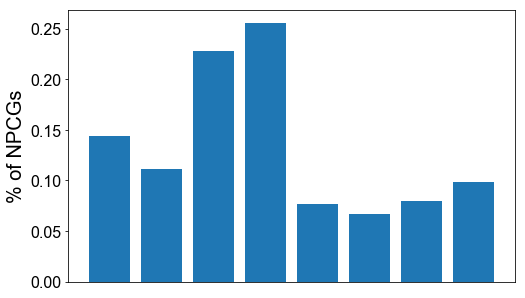

In [23]:
fig = plt.figure(figsize=(8, 5))
npcgs_per_cluster = nodes_enriched[['Cluster', 'NPCG']].groupby('Cluster').NPCG.mean()# / npcgs.shape[0]
plt.bar(x=np.arange(1, nodes_enriched.Cluster.nunique()+1),
        height=npcgs_per_cluster)
plt.ylabel('% of NPCGs', fontsize=20)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#_ = plt.xticks(np.arange(1, len(relevant_clusters)+1), labels=['Cluster {}'.format(i+1) for i in range(len(relevant_clusters))],
#               rotation=90, fontsize=20)
fig.savefig(os.path.join(model_dir, 'cluster_stats_npcgs.svg'))

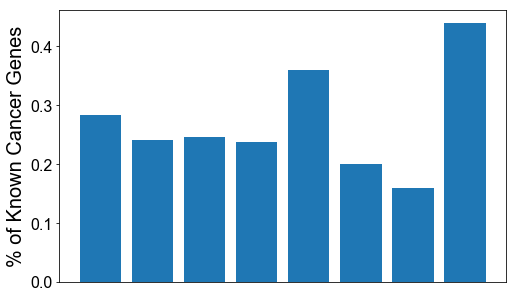

In [24]:
fig = plt.figure(figsize=(8, 5))
npcgs_per_cluster = nodes_enriched[['Cluster', 'label']].groupby('Cluster').label.mean()# / npcgs.shape[0]
plt.bar(x=np.arange(1, nodes_enriched.Cluster.nunique()+1),
        height=npcgs_per_cluster)
plt.ylabel('% of Known Cancer Genes', fontsize=20)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#_ = plt.xticks(np.arange(1, len(relevant_clusters)+1), labels=['Cluster {}'.format(i+1) for i in range(len(relevant_clusters))],
#               rotation=90, fontsize=20)
#plt.ylim([0.1, 0.48])
fig.savefig(os.path.join(model_dir, 'cluster_stats_knowns.svg'))

In [17]:
essential_genes = pd.read_csv(achilles_data_path).T
essential_genes.columns = essential_genes.loc['Unnamed: 0']
essential_genes.drop('Unnamed: 0', inplace=True)
essential_genes['Name'] = [i.split('(')[0].strip() for i in essential_genes.index]
essential_genes.set_index('Name', inplace=True)
# sum and join with nodes
essentiality = (essential_genes < -0.5).sum(axis=1)
nodes_enriched = nodes_enriched.join(essentiality.rename('essentiality'), how='inner')

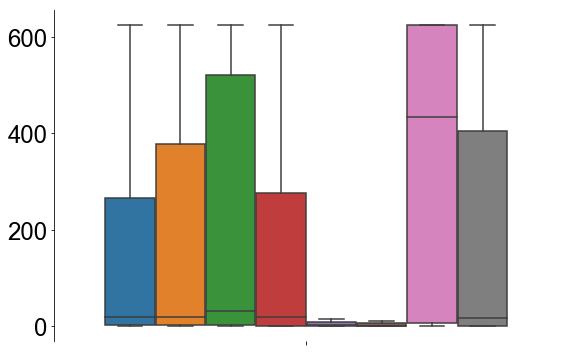

In [26]:
fig = plt.figure(figsize=(8, 5))
g = sns.boxplot(data=pd.melt(nodes_enriched[['Cluster', 'essentiality']], id_vars='Cluster'),
            x='variable', y='value', hue='Cluster', showfliers=False)
g.legend().remove()
plt.gca().tick_params(axis='both', labelsize=24)
plt.gca().set_xticklabels([])
plt.ylabel(None, fontsize=28)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'cluster_stats_essentiality.svg'))

90 96


Text(0.5, 0, '')

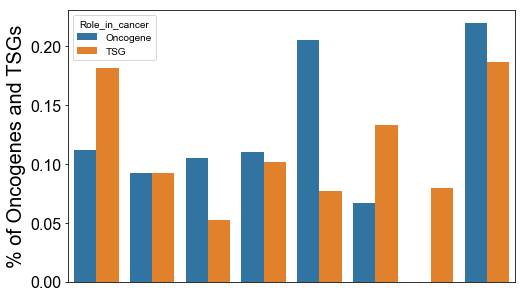

In [64]:
nodes_enriched['Oncogene'] = 0
nodes_enriched['TSG'] = 0
oncogenes = cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index
tsgs = cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index
nodes_enriched.loc[nodes_enriched.index.isin(oncogenes), 'Oncogene'] = 1
nodes_enriched.loc[nodes_enriched.index.isin(tsgs), 'TSG'] = 1
print (nodes_enriched.Oncogene.sum(), nodes_enriched.TSG.sum())

fig = plt.figure(figsize=(8, 5))
oncogenes_per_cluster = pd.DataFrame(nodes_enriched[['Cluster', 'Oncogene']].groupby('Cluster').Oncogene.mean().rename('value'))# / npcgs.shape[0]
tsgs_per_cluster = pd.DataFrame(nodes_enriched[['Cluster', 'TSG']].groupby('Cluster').TSG.mean().rename('value'))# / npcgs.shape[0]
oncogenes_per_cluster['Role_in_cancer'] = 'Oncogene'
tsgs_per_cluster['Role_in_cancer'] = 'TSG'
combined = pd.concat((oncogenes_per_cluster, tsgs_per_cluster))
combined['Cluster'] = combined.index
sns.barplot(data=combined, x='Cluster', y='value', hue='Role_in_cancer')
plt.ylabel('% of Oncogenes and TSGs', fontsize=20)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xlabel(None)

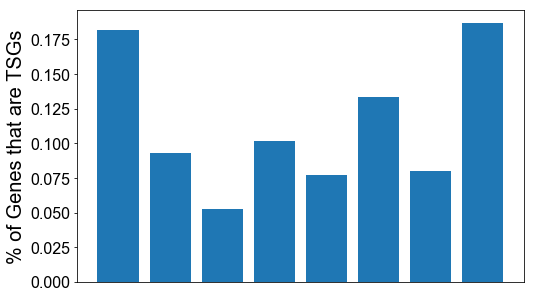

In [40]:
fig = plt.figure(figsize=(8, 5))
tsgs_per_cluster = nodes_enriched[['Cluster', 'TSG']].groupby('Cluster').TSG.mean()# / npcgs.shape[0]
plt.bar(x=np.arange(1, nodes_enriched.Cluster.nunique()+1),
        height=tsgs_per_cluster)
plt.ylabel('% of Genes that are TSGs', fontsize=20)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#_ = plt.xticks(np.arange(1, len(relevant_clusters)+1), labels=['Cluster {}'.format(i+1) for i in range(len(relevant_clusters))],
#               rotation=90, fontsize=20)
#fig.savefig(os.path.join(model_dir, 'cluster_stats_knowns.svg'))

In [ ]:
nodes_en

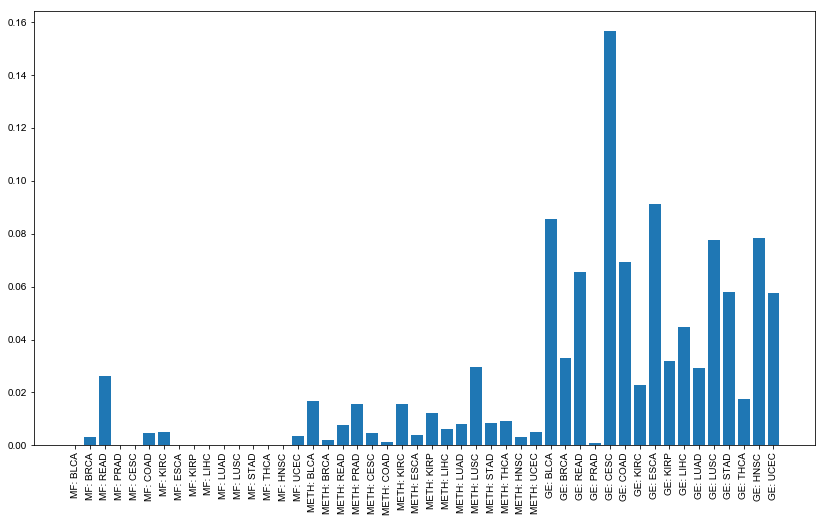

In [8]:
features_df = pd.DataFrame(features, index=node_names[:, 1], columns=feature_names)
fig = plt.figure(figsize=(14, 8))
plt.bar(x=list(range(high_feat_contrib.shape[1])),
        height=features_df[features_df.index == 'CDK2'].values.reshape(-1))
_ = plt.xticks(list(range(features_df.shape[1])), labels=features_df.columns, rotation=90)

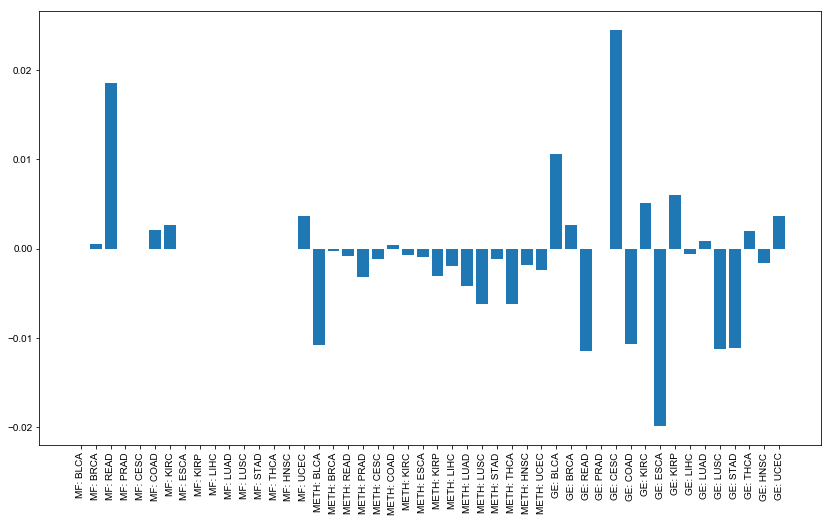

In [9]:
fig = plt.figure(figsize=(14, 8))
plt.bar(x=list(range(high_feat_contrib.shape[1])),
        height=high_feat_contrib[high_feat_contrib.index == 'CDK2'].values.reshape(-1))
_ = plt.xticks(list(range(high_feat_contrib.shape[1])), labels=high_feat_contrib.columns, rotation=90)

In [10]:
high_feat_contrib.iloc[:, 16:32].mean(axis=1).sort_values(ascending=False).head()

REG3A    0.044
REG1B    0.038
HAVCR1   0.034
LILRB2   0.030
TLX3     0.021
dtype: float64

In [12]:
#high_feat_contrib.iloc[:, 16:32].mean().sort_values(ascii).head()

In [13]:
cluster_pathways_highconf = []
for cluster_number in flat_clusters_series.unique():
    cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
    cluster_genes = nodes[nodes.Name.isin(high_feat_contrib.iloc[cluster_gene_indices].index)]
    #cluster_genes = nodes_highfeat[nodes_highfeat.index.isin(cluster_gene_indices)]
    #print ("Cluster {} contains {} genes".format(cluster_number, cluster_genes.shape[0]))
    top_pathways = get_pathway_enrichment(cluster_genes, cluster_number, model_dir)
    cluster_pathways_highconf.append((cluster_number, top_pathways))

In [14]:
pd.reset_option('display.float_format')
cluster_pathways_highconf[4][1]

,Pvalue,Count,Size,Term
1,2.046324e-19,22,124,Cell cycle
2,1.966939e-10,14,112,Oocyte meiosis
3,1.913606e-07,10,86,Progesterone-mediated oocyte maturation
4,2.642778e-07,9,68,p53 signaling pathway
5,7.462776e-06,6,36,DNA replication


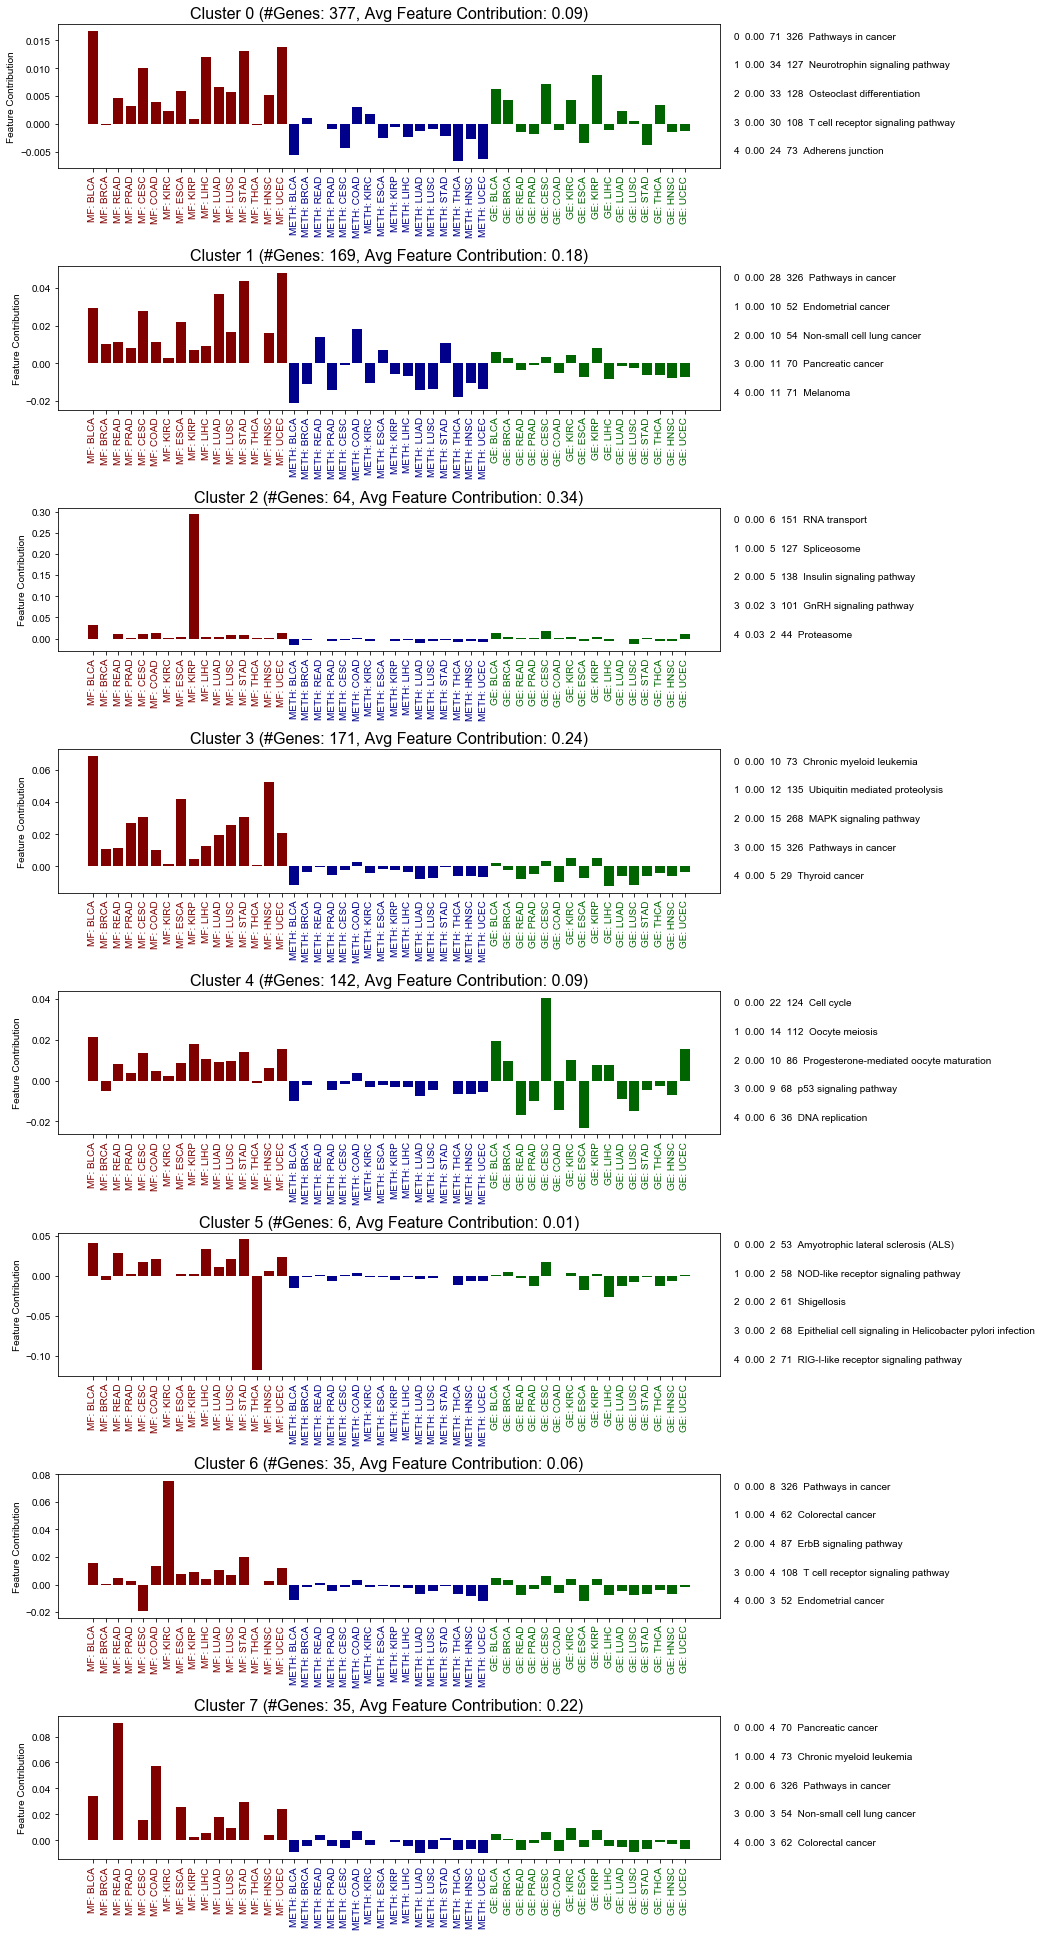

In [15]:
sum_of_all = 0
n_clusters = flat_clusters_series.nunique()
fig, axes = plt.subplots(nrows=n_clusters, ncols=2,
                         figsize=(15, n_clusters*3 + 3),
                         gridspec_kw={'width_ratios': [3, 1]}
                        )

def plot_representative_heatmap(ax, rep, xlabels, title=None):
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]
    vmax = rep.max()
    vmin = rep.min()
    print ("Max and min ", vmax, vmin)
    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


for cluster_number in flat_clusters_series.unique():
    # find the genes in the current cluster
    cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
    cluster_genes = nodes[nodes.Name.isin(high_feat_contrib.iloc[cluster_gene_indices].index)]
    
    # compute the representative for that cluster
    features_of_cluster = high_feat_contrib.iloc[cluster_gene_indices]
    representative = features_of_cluster.mean(axis=0)
    representative_std = features_of_cluster.std(axis=0)
    # plot barplot for representative
    plot_representative(axes[cluster_number][0], representative, representative_std, representative.index,
             title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(cluster_number,
                                                                                         cluster_genes.shape[0],
                                                                                         representative.sum()
                                                                                        )
            )
    # plot the pathways next to it
    plot_pathway_information(axes[cluster_number][1], cluster_pathways_highconf[cluster_number][1])
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'cluster_representatives_highconf_{}.pdf'.format(flat_clusters_series.nunique())))

(48,)
Max and min  0.09082470211599554 0.00022232883077647004
(16, 3)
(1, 3)
(16, 3)
(1, 3)
(16, 3)
(1, 3)


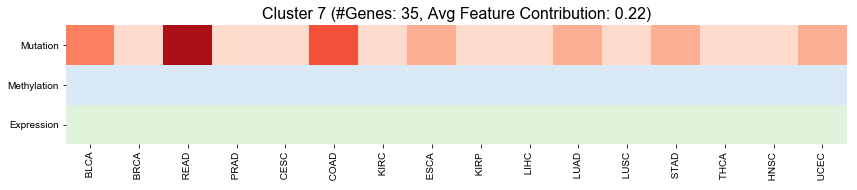

In [138]:
cluster_num = 7
indices = flat_clusters_series[flat_clusters_series == cluster_num].index
contribs = high_feat_contrib.iloc[indices]
rep = contribs.mean(axis=0)

fig = plt.figure(figsize=(14, 2))
ax = plt.subplot(1, 1, 1)
utils.lrp_heatmap_plot(fig, ax, rep.values, rep.index,
                       title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(cluster_num, indices.shape[0], rep.sum())
                      )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.savefig(os.path.join(model_dir, 'cluster_{}_heatmap.svg'.format(cluster_num)))

In [96]:
gene_name = 'COIL'

cluster_number = flat_clusters_series[clu.dendrogram_row.reordered_ind.index(nodes[nodes.Name == gene_name].index)]
cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
cluster_genes = nodes[nodes.index.isin(cluster_gene_indices)]
print ("Cluster {} contains {} genes".format(cluster_number, cluster_genes.shape[0]))
#cluster_genes.to_csv(os.path.join(model_dir, 'cluster_{}_gene_{}.tsv'.format(cluster_number, gene_name)), sep='\t')

Cluster 2 contains 3893 genes


In [108]:
start_gene = 'HDC'
end_gene = 'STIM1'
start_idx = clu.dendrogram_row.reordered_ind.index(nodes[nodes.Name == start_gene].index)
end_idx = clu.dendrogram_row.reordered_ind.index(nodes[nodes.Name == end_gene].index)
print (start_idx, end_idx)
relevant_indices = clu.dendrogram_row.reordered_ind[start_idx:end_idx]
relevant_indices
nodes[nodes.index.isin(relevant_indices)].set_index('ID')#.to_csv(os.path.join(model_dir, 'interesting_cluster_{}_{}.tsv'.format(start_gene, end_gene)), sep='\t')

10550 10573


,Name
ID,
ENSG00000162458,FBLIM1
ENSG00000130164,LDLR
ENSG00000086730,LAT2
ENSG00000177971,IMP3
ENSG00000099901,RANBP1
ENSG00000089127,OAS1
ENSG00000181804,SLC9A9
ENSG00000184939,ZFP90
ENSG00000165092,ALDH1A1


## Are Newly Predicted Cancer Genes Interaction or Feature Driven?

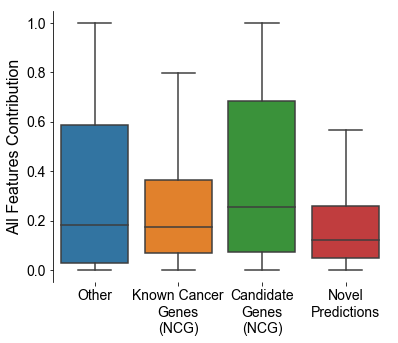

In [56]:
npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
oncokb, known, candidate = get_cancer_genes()
npcgs.set_index('Name', inplace=True)
contribution_sum_df = pd.DataFrame(feat_contrib_df.sum(axis=1), columns=['Feature_Sum'])
contribution_sum_df['Gene_Set'] = 'Other'
#contribution_sum_df.loc[contribution_sum_df.index.isin(candidate), 'Gene_Set'] = 'Candidate\nCancer Gene'
#contribution_sum_df.loc[contribution_sum_df.index.isin(oncokb['Hugo Symbol']), 'Gene_Set'] = 'OncoKB'
contribution_sum_df.loc[contribution_sum_df.index.isin(known), 'Gene_Set'] = 'Known Cancer\nGenes\n(NCG)'
contribution_sum_df.loc[contribution_sum_df.index.isin(candidate), 'Gene_Set'] = 'Candidate\nGenes\n(NCG)'
contribution_sum_df.loc[contribution_sum_df.index.isin(npcgs.index), 'Gene_Set'] = 'Novel\nPredictions'
contribution_sum_df.Gene_Set.value_counts()
contribution_sum_df.Feature_Sum = contribution_sum_df.Feature_Sum.abs()
contribution_sum_df.loc[contribution_sum_df.Feature_Sum > 1, 'Feature_Sum'] = 1

fig = plt.figure(figsize=(6, 5))
sns.boxplot(data=contribution_sum_df, x='Gene_Set', y='Feature_Sum', showfliers=False, 
            order=['Other', 'Known Cancer\nGenes\n(NCG)', 'Candidate\nGenes\n(NCG)', 'Novel\nPredictions'])
plt.ylabel('All Features Contribution', fontsize=16)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(axis='both', labelsize=14)
fig.savefig(os.path.join(model_dir, 'feature_contribution_npcgs.svg'))

In [73]:
contrib_df_copy = feat_contrib_df.copy()
contrib_df_copy[contrib_df_copy < 0] = 0
contrib_df_copy.loc['Omics_Type', :] = [i[0] for i in feat_contrib_df.columns.str.split(':')]
omics_contributions = contrib_df_copy.T.groupby('Omics_Type').sum(axis=1).T

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def minmax(x):
    return x / x.sum(axis=0)
omics_contributions_probs = omics_contributions.apply(minmax, axis=1)

In [74]:
omics_contributions_probs['Gene_Set'] = 'Other'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(known), 'Gene_Set'] = 'Known Cancer\nGenes\n(NCG)'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(candidate), 'Gene_Set'] = 'Candidate\nGenes\n(NCG)'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(high_feat_contrib.index), 'Gene_Set'] = 'Top 1000\nPredictions'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(npcgs.index), 'Gene_Set'] = 'Novel\nPredictions'

In [75]:
omics_contributions_probs.Gene_Set.value_counts()

Other                         11068
Candidate\nGenes\n(NCG)        1094
Top 1000\nPredictions           851
Known Cancer\nGenes\n(NCG)      405
Novel\nPredictions              209
Name: Gene_Set, dtype: int64

In [76]:
assert ((omics_contributions_probs.index == contribution_sum_df.index).all())
omics_contributions_highconf = omics_contributions_probs[contribution_sum_df.Feature_Sum > 0.25]
omics_contributions_highconf.shape

(5932, 4)

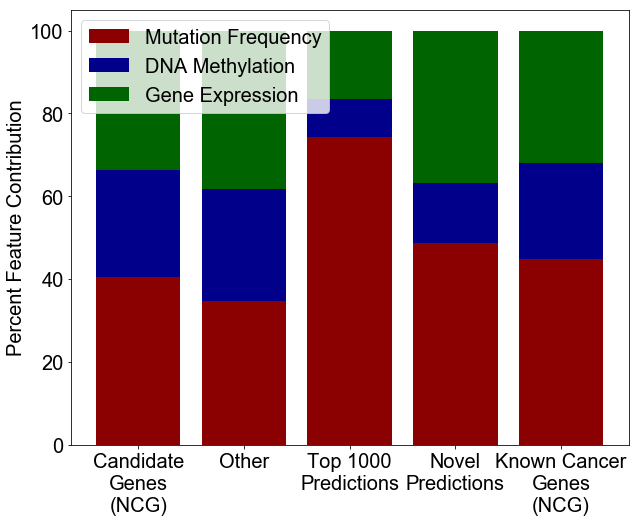

In [77]:
stacked_barplot_vals = {}
gene_sets = omics_contributions_highconf.Gene_Set.unique()
groups = list(range(len(gene_sets)))
for omics in ['MF', 'METH', 'GE']:
    omics_vals = []
    for gene_set in gene_sets:
        omics_vals.append(omics_contributions_highconf.loc[omics_contributions_highconf.Gene_Set == gene_set, omics].mean())
    stacked_barplot_vals[omics] = omics_vals

df = pd.DataFrame(stacked_barplot_vals)
totals = [i+j+k for i,j,k in zip(df['MF'], df['METH'], df['GE'])]
mutation_bars = [i / j * 100 for i,j in zip(df['MF'], totals)]
methylation_bars = [i / j * 100 for i,j in zip(df['METH'], totals)]
expression_bars = [i / j * 100 for i,j in zip(df['GE'], totals)]

fig = plt.figure(figsize=(10, 8))
plt.bar(groups, mutation_bars, color='darkred', label='Mutation Frequency')
plt.bar(groups, methylation_bars, bottom=mutation_bars, color='darkblue', label='DNA Methylation')
plt.bar(groups, expression_bars, bottom=[i+j for i,j in zip(mutation_bars, methylation_bars)],
        color='darkgreen', label='Gene Expression')

plt.legend(loc='upper left', ncol=1, fontsize=20)
plt.ylabel('Percent Feature Contribution', fontsize=20)
_ = plt.xticks(groups, gene_sets, fontsize=15)
plt.gca().tick_params(axis='both', which='major', labelsize=20)
fig.savefig(os.path.join(model_dir, 'omics_contributions_genesets.svg'))

In [78]:
stacked_barplot_vals

{'MF': [0.40608068789538126,
  0.3479197657015513,
  0.7421694776013061,
  0.48716646126043595,
  0.4493557294469054],
 'METH': [0.25657453719844014,
  0.2702808960905343,
  0.0919055470174753,
  0.14415456250500588,
  0.2302858169229959],
 'GE': [0.33734477490617854,
  0.38179933820791506,
  0.16592497538121848,
  0.3686789762345581,
  0.32035845363009857]}

## Finding Strongly-Connected Components (SCCs) in Interaction Contribution

## Parameters:

* `compute_optimal_cutoff`: Whether to compute the cutoff for the number of SCCs

In [12]:
compute_optimal_cutoff = False

### Load PPI Edge Contributions

In [8]:
lrp_neighbor_matrix = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'support_0_mean_sum.npy'))
count = 1
for i in range(5):
    p = os.path.join(model_dir, 'lrp_sigmoid', 'support_{}_mean_sum.npy'.format(i))
    if os.path.isfile(p):
        lrp_neighbor_matrix += np.load(p)
        count += 1
        print ("Loaded and added neighbor contributions with support {}".format(i))
lrp_neighbor_matrix = lrp_neighbor_matrix / float(count)
lrp_neighbor_matrix.min(), lrp_neighbor_matrix.max()

Loaded and added neighbor contributions with support 0
Loaded and added neighbor contributions with support 1


(-78.10830990555824, 72.98056168227582)

In [9]:
(lrp_neighbor_matrix < 0).sum()

246189

In [10]:
lrp_neighbor_matrix_abs = lrp_neighbor_matrix.copy()
lrp_neighbor_matrix_abs[lrp_neighbor_matrix_abs < 0] = 0
C_abs = nx.from_pandas_adjacency(pd.DataFrame(lrp_neighbor_matrix_abs, index=node_names[:, 1], columns=node_names[:, 1]), create_using=nx.MultiDiGraph)

def get_number_of_modules(threshold):
    to_remove = []
    for u, v, weight in C_abs.edges(data='weight'):
        if weight < threshold:
            to_remove.append((u, v))
    C_abs_copy = C_abs.copy()
    C_abs_copy.remove_edges_from(to_remove)
    module_sizes = [len(c) for c in sorted(nx.strongly_connected_components(C_abs_copy), key=len, reverse=True) if len(c) > 5]
    return len(module_sizes)

C_abs.remove_edges_from(list(nx.selfloop_edges(C_abs)))
sorted(C_abs.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]

[('RITA1', 'NEK2', {'weight': 5.848961219825749}),
 ('ATMIN', 'WRNIP1', {'weight': 5.719151518863786}),
 ('EXOSC2', 'ST6GALNAC1', {'weight': 4.395462125936763}),
 ('ARID3B', 'HELZ', {'weight': 3.3453603560771814}),
 ('CRAT', 'PEX5', {'weight': 3.2524595724024263}),
 ('ZNF181', 'DDX46', {'weight': 3.145780644502213}),
 ('MXD1', 'VDR', {'weight': 3.030064549193373}),
 ('PLA2R1', 'PLA2G10', {'weight': 2.920743430950946}),
 ('HIST2H4B', 'HIST2H3A', {'weight': 2.8685326444259185}),
 ('HIST2H4B', 'HIST2H3C', {'weight': 2.828029795970691})]

In [13]:
if compute_optimal_cutoff:
    thresholds = np.arange(0.01, 0.35, 0.02)
    number_of_modules = []
    for thr in thresholds:
        number_of_modules.append(get_number_of_modules(thr))
    number_of_modules
    
    fig = plt.figure(figsize=(14, 8))
    plt.bar(x=list(range(len(number_of_modules))), height=number_of_modules)
    _ = plt.xticks(ticks=list(range(len(number_of_modules))), labels=['{0:.2f}'.format(i) for i in thresholds], fontsize=15)
    plt.xlabel('Thresholds for Edge Weight', fontsize=20)
    plt.ylabel('Number of Modules of Size > 5', fontsize=20)
    print (number_of_modules)
    plt.gca().tick_params(axis='y', which='major', labelsize=20)
    fig.savefig(os.path.join(model_dir, 'SCCs', 'module_sizes_posonly.svg'))

In [14]:
min_edge_weight = 0.19

nw_thr = np.where(lrp_neighbor_matrix_abs <= min_edge_weight, 0, lrp_neighbor_matrix)
nw_thr.nonzero()[0].shape, lrp_neighbor_matrix.nonzero()[0].shape

((16951,), (517965,))

In [18]:
pred['Pred_Cancer_Gene'] = False
pred.loc[pred.Prob_pos >= 0.89, 'Pred_Cancer_Gene'] = True
pred = pred.join(essentiality.rename('essentiality'), on='Name', how='inner')

In [41]:
# get the NCG cancer genes
known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

oncokb_genes = pd.read_csv('/project/gcn/diseasegcn/data/pancancer/oncoKB/cancerGeneList.txt', sep='\t')
# remove low confidence genes
oncokb_no_ncg_highconf = oncokb_genes[oncokb_genes['# of occurrence within resources (Column D-J)'] >= 3]

# comprehensive characterization paper genes
path = '../data/pancancer/comprehensive_characterization_of_cancer_driver_genes_and_mutations/comprehensive_characterization_cancer_genes.csv'
cancer_genes_paper = pd.read_csv(path, sep='\t', header=3)
cancer_genes_paper = pd.Series(cancer_genes_paper.Gene.unique())

# driverDB
driverdb_genes = []
thresholds_study = {'mutation': 25, 'CNV': 5, 'methylation': 2}
for evidence in ['mutation', 'CNV', 'methylation']:
    driverdb_data = pd.read_csv('../data/pancancer/driverdb/{}_download_tab.txt'.format(evidence), sep='\t')
    all_driver_genes = []
    for index, row in driverdb_data.iterrows():
        all_driver_genes += [i.strip() for i in row.driver_gene.split(',') if not i.strip() == '']
    study_counts = pd.Series(all_driver_genes).value_counts()
    driverdb_genes += list(study_counts[study_counts > thresholds_study[evidence]].index)
driverdb_genes = pd.Series(list(set(driverdb_genes)))

# OnGene + TSGene
oncogenes = pd.read_csv('../data/pancancer/ongene_tsgene/Human_Oncogenes.txt', sep='\t')
tsgs = pd.read_csv('../data/pancancer/ongene_tsgene/Human_TSGs.txt', sep='\t')
cancer_genes = list(set(list(oncogenes.OncogeneName) + list(tsgs.GeneSymbol)))

# COSMIC CGC
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv')
cgc = list(set(cgc['Gene Symbol']))

pred['CGC'] = False
pred.loc[pred.Name.isin(cgc), 'CGC'] = True
pred['Bailey'] = False
pred.loc[pred.Name.isin(cancer_genes_paper), 'Bailey'] = True
pred['NCGCandidates'] = False
pred.loc[pred.Name.isin(candidate_cancer_genes), 'NCGCandidates'] = True
pred['OncoKB'] = False
pred.loc[pred.Name.isin(oncokb_genes['Hugo Symbol']), 'OncoKB'] = True
pred['DriverDB'] = False
pred.loc[pred.Name.isin(driverdb_genes), 'DriverDB'] = True
pred['ONGene_TSGene'] = False
pred.loc[pred.Name.isin(cancer_genes), 'ONGene_TSGene'] = True

In [15]:
nw_thr_df = pd.DataFrame(data=nw_thr, index=node_names[:, 1], columns=node_names[:, 1])
G = nx.from_pandas_adjacency(nw_thr_df, create_using=nx.MultiDiGraph)
nx.set_node_attributes(G=G, values=pred.set_index('Name')['Prob_pos'].to_dict(), name='OutputProb')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['label'].to_dict(), name='KnownCancerGene')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['Pred_Cancer_Gene'].to_dict(), name='PredictedCancerGene')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['essentiality'].to_dict(), name='Essentiality')

nx.set_node_attributes(G=G, values=pred.set_index('Name')['CGC'].to_dict(), name='CGC')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['Bailey'].to_dict(), name='BaileyEtAl')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['NCGCandidates'].to_dict(), name='NCGCandidates')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['OncoKB'].to_dict(), name='OncoKB')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['DriverDB'].to_dict(), name='DriverDB')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['ONGene_TSGene'].to_dict(), name='ONGeneTSGene')

print ([len(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True) if len(c) > 1])
print (len(max(nx.strongly_connected_components(G), key=len)))
nodes_component = list(max(nx.strongly_connected_components(G), key=len))
x = pd.DataFrame(nodes_component, columns=['Name'])
all_components = [list(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True) if len(c) > 1]

[47, 16, 11, 11, 9, 9, 7, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
47


In [19]:
comp_no = 1
for comp in all_components:
    if 'FEZF2' in comp:
        print (comp_no)
        print (comp)
    comp_no += 1

In [45]:
node_names_df = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
for i in range(10):
    fname = os.path.join(model_dir, 'SCCs', 'thr_019_noneg',
                         'lrp_neighbors_new_comp_{}_thr_{}.gml'.format(i+1, min_edge_weight))
    comp = all_components[i]
    nx.write_gml(G.subgraph(comp), path=fname)
    fname_nodes = os.path.join(model_dir, 'lrp_neighbors_new_comp_{}_thr_{}_nodes.csv'.format(i+1, min_edge_weight))
    nodes[nodes.Name.isin(comp)].to_csv(fname_nodes, sep='\t')
    print ("Graph written to: {}".format(fname))

Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_1_thr_0.19.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_2_thr_0.19.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_3_thr_0.19.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_4_thr_0.19.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_5_thr_0.19.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_6_thr_0.19.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_7_thr_0.19.gml
Graph written to: ../data/GCN/training/final_TCG

Text(0, 0.5, 'Average Essentiality')

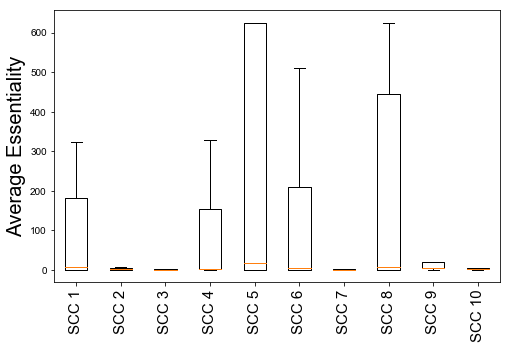

In [63]:
essentiality_for_sccs = []
essentiality_err = []
for i in range(10):
    mean_ess = pred[pred.Name.isin(all_components[i])].essentiality
    essentiality_for_sccs.append(mean_ess)
    essentiality_err.append(mean_ess.std())

fig = plt.figure(figsize=(8, 5))
_ = plt.boxplot(essentiality_for_sccs, showfliers=False)
_ = plt.xticks(ticks=np.arange(1, 11), labels=['SCC {}'.format(j+1) for j in range(10)], fontsize=15, rotation=90)
plt.ylabel('Average Essentiality', fontsize=20)

In [ ]:
plt.boxplot()

Text(0, 0.5, '# of Known Cancer Genes')

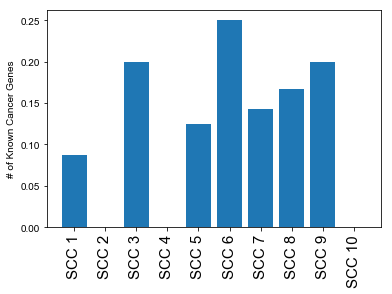

In [51]:
sum_known_comp = []
for i in range(10):
    comp_stats = pred[pred.Name.isin(all_components[i])].label
    sum_known_comp.append(comp_stats.mean())

plt.bar(x=np.arange(10), height=sum_known_comp)
_ = plt.xticks(ticks=np.arange(10), labels=['SCC {}'.format(j+1) for j in range(10)], fontsize=15, rotation=90)
plt.ylabel('# of Known Cancer Genes')

## Run Pathway/Enrichment Analyses for SCCs

### KEGG Pathway Analysis

In [14]:
pathway_sccs = []
for i in range(10):
    pathway_sccs.append(get_pathway_enrichment(nodes[nodes.Name.isin(all_components[i])], nodes, i, model_dir))

### GO Enrichment Analysis

In [30]:
# Get the data
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_human.keys(), # List of human protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2020-01-01) 47,337 GO Terms
HMS:0:00:08.282228 323,107 annotations READ: gene2go 
1 taxids stored: 9606
BP 17,541 annotated human genes
CC 18,648 annotated human genes
MF 17,384 annotated human genes

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,711 of 20,913 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 85% 17,755 of 20,913 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,699 of 20,913 population items found in association


In [126]:
for comp in range(10):
    geneids_study = [int(i) for i in list(ut.get_entrez_from_symbol(all_components[comp]).index) if not i is None]
    goea_results_all = goeaobj.run_study(geneids_study)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    out_dir = os.path.join(model_dir, 'SCCs', 'thr_019_noneg')
    #plot_results(os.path.join(out_dir, 'SCC_{}_goenrichment.png'.format(comp+1)), goea_results_sig)
    goeaobj.wr_xlsx(os.path.join(out_dir, 'SCC_{}_goenrichment.xlsx'.format(comp+1)), goea_results_sig)

querying 1-47...done.
Finished.
1 input query terms found no hit:
	['SEPT3']

Run BP Gene Ontology Analysis: current study set of 46 IDs ...
 98%     45 of     46 study items found in association
100%     46 of     46 study items found in population(20913)
Calculating 12,189 uncorrected p-values using fisher_scipy_stats
  12,189 GO terms are associated with 16,711 of 20,913 population items
     542 GO terms are associated with     45 of     46 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 46 IDs ...
100%     46 of     46 study items found in association
100%     46 of     46 study items found in population(20913)
Calculating 1,731 uncorrected p-values using fisher_scipy_stats
   1,731 GO terms are associated with 17,75

## LRP Neighbor Contributions Introduce no New Interactions

In [ ]:
import lrp

In [6]:
interpreter = lrp.LRP(model_dir=model_dir)

Calculating Chebyshev polynomials up to order 1...


In [52]:
lrp_scores = interpreter.compute_lrp('APC')
mean_feat, std_feat, mean_neighbors, std_neighbors = lrp_scores

Now: APC


In [56]:
nn_contrib_s0 = pd.DataFrame(mean_neighbors[1], index=node_names[:, 1], columns=node_names[:, 1])
G = nx.from_pandas_adjacency(nn_contrib_s0)
A = nx.from_pandas_adjacency(pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1]))
G.remove_edges_from(G.selfloop_edges())
G.number_of_edges()

NameError: name 'mean_neighbors' is not defined

In [54]:
gene_name = 'APC'
contributers_tp53 = list(G.neighbors(gene_name))
same = 0
for neighbor in A.neighbors(gene_name):
    if not neighbor in contributers_tp53:
        print (neighbor)
    else:
        same += 1
same

194

In [55]:
A.number_of_edges(), G.number_of_edges()

(252189, 237795)

In [61]:
len(list(contrib_all.neighbors('APC')))

194

In [65]:

def edge_exists(source, target):
    if A.has_edge(source, target):

24.0

In [75]:
count = 0
for (u, v) in A.edges():
    count += 1
    if not contrib_all.has_edge(u, v):
        print (u, v)

MMP20 DSPP
C1QTNF1 C1QTNF6


In [74]:
A.number_of_edges(), G.number_of_edges(), contrib_all.number_of_edges()

(252189, 237795, 252187)

In [57]:
A = nx.from_pandas_adjacency(pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1]))
len(list(A.neighbors('ZHX2')))

32

In [54]:
feat_contrib_df[feat_contrib_df.sum(axis=1).abs() > 2.5].shape

(840, 48)

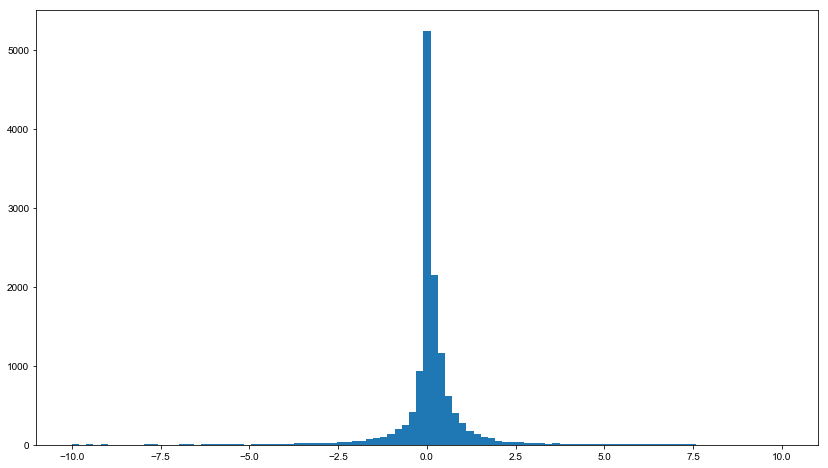

In [49]:
fig = plt.figure(figsize=(14, 8))
_= plt.hist(feat_contrib_df.sum(axis=1), bins=np.linspace(-10, 10, 100))